In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Integer, Real
from skopt.utils import use_named_args

from simulation_utils.calibration import Calibrator, compute_cosine_similarity_pd, _sample_pairs
from simulation_utils.datasets import ml_100k, bx_implicit, DataStats, ml_1m, az_music
from simulation_utils.preference import LatentDirichletAllocationCSR, IndianBuffetProcessCSR, generate_ibp_itemwise, generate_lda, generate_lda_nbp
from simulation_utils.observation import PopularityObservationCSR, UniformObservationCSR
from simulation_utils.observation import sample_uniform_n, sample_popular_n, TruncParetoProfile
from simulation_utils.utils import TruncatedPareto
from simulation_utils.utils import truncated_beta_binomial, truncated_pareto
# %matplotlib inline

In [2]:
def ibp_unif_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                    m=20.00000045, obs_alpha=0.510528, upper=737,
                    fname='lda_pop.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [3]:
def ibp_pop_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                   m=20.00000045, obs_alpha=0.510528, upper=737,
                   fname='lda_pop.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [4]:
def lda_pop_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                   m=20.00000045, alpha=0.510528, upper=737, 
                   fname='lda_pop.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [5]:
def lda_unif_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                    m=20.00000045, alpha=0.510528, upper=737, 
                    fname='lda_unif.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [6]:
def compute_density(data):
    nusers = len(data['user'].unique())
    nitems = len(data['item'].unique())
    npairs = len(data)
    density = npairs / nitems / nusers
    return nusers, nitems, npairs, density

In [7]:
def compute_data_stats(data):
    pairs = data.loc[:, ['user', 'item']]
    user_activity = pairs.groupby('user', as_index=False).count().rename(columns={'item': 'count'})
    item_popularity = pairs.groupby('item', as_index=False).count().rename(columns={'user': 'count'})
    return user_activity, item_popularity

In [8]:
def summarize_dataset(name, data_func, *args, **kwargs):
    if isinstance(data_func, pd.DataFrame):
        dataset = data_func
    else:
        dataset = data_func(*args, **kwargs)
    colname = dataset.columns
    if not {'user', 'item'}.issubset(colname):
        dataset.rename(columns={colname[0]: 'user',
                                colname[1]: 'item'},
                       inplace=True)
    dataset = dataset[['user', 'item']]
    data_meta = compute_density(dataset)
    data_meta_stats = tuple([name, *data_meta])
    
    user_activity, item_popularity = compute_data_stats(dataset)
    user_activity['dataset'] = name
#     user_activity.drop('user', axis=1, inplace=True)
    item_popularity['dataset'] = name
#     item_popularity.drop('item', axis=1, inplace=True)
    item_popularity['rank'] = item_popularity['count'].rank(method='min', ascending=False)

    user_activity_stats = user_activity['count'].rename(name).describe()
    item_popularity_stats = item_popularity['count'].rename(name).describe()
    return data_meta_stats, user_activity_stats, item_popularity_stats, user_activity, item_popularity

In [9]:
def make_grids(figsize=(14, 6), ngrids_left=3, ngrids_right=1):
    fig = plt.figure(figsize=figsize)
    gs_left = GridSpec(ngrids_left, 1)
    gs_left.update(left=0.05, right=0.48, wspace=0.05, hspace=0.05)
    for i in range(ngrids_left):
        ax = plt.subplot(gs_left[i, 0])
    for ax in fig.axes[:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[1:]:
        ax.spines['top'].set_visible(False)

    gs_right = GridSpec(ngrids_right, 1)
    gs_right.update(left=0.55, right=0.98, wspace=0.05, hspace=0.05)
    for i in range(ngrids_right):
        ax = plt.subplot(gs_right[i, 0])
    for ax in fig.axes[ngrids_left:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[ngrids_left+1:]:
        ax.spines['top'].set_visible(False)
    return fig, fig.axes

In [10]:
def plot_stats(base, simulated, base_arg=(), args=(), ylim_left=None, ylim_left2=None, ylim_left4=None, mrated=1):
    """
    Args:
        base (`tuple` of str, function): name and data function
        simulated (`tuple` of `str`, `function`): name and data function
        args: position args for simulated data function
    """
    ml_name, data_func, lda_name, simulated_lda_func = *base, *simulated
    data = data_func(*base_arg)
    data['rating'] = 1
    if callable(simulated_lda_func):
        simulated_lda = simulated_lda_func(*args)
    else:
        simulated_lda = simulated_lda_func
    simulated_lda['rating'] = 1
    ml_meta, ml_uastats, ml_ipstats, ml_ua, ml_ip = summarize_dataset(ml_name, data)
    lda_meta, lda_uastats, lda_ipstats, lda_ua, lda_ip = summarize_dataset(lda_name, simulated_lda)
    # show data stats
    df = pd.DataFrame.from_records([ml_meta, lda_meta],
                                   columns=['dataset', 'nusers', 'nitems', 'npairs', 'density'])
    print('dataset stats')
    print(df)
    df = pd.concat([ml_ipstats, lda_ipstats], axis=1)
    print('item popularity stats')
    print(df)
    df = pd.concat([ml_uastats, lda_uastats], axis=1)
    print('user profile stats')
    print(df)
    # minimum n ratings
    ml_upairs = ml_ua[ml_ua['count'] >= mrated]['user'].values
    ml_ipairs = ml_ip[ml_ip['count'] >= mrated]['item'].values
    lda_upairs = lda_ua[lda_ua['count'] >= mrated]['user'].values
    lda_ipairs = lda_ip[lda_ip['count'] >= mrated]['item'].values
    data_ucosine = data[data['user'].isin(ml_upairs)]
    data_icosine = data[data['item'].isin(ml_ipairs)]
    simulated_lda_ucosine = simulated_lda[simulated_lda['user'].isin(lda_upairs)]
    simulated_lda_icosine = simulated_lda[simulated_lda['item'].isin(lda_ipairs)]

    ml_dcorr = compute_cosine_similarity_pd(data_icosine, _sample_pairs, 'item', 'user')
    lda_dcorr = compute_cosine_similarity_pd(simulated_lda_icosine, _sample_pairs, 'item', 'user')
    data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                           pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                          ignore_index=True)
    # plot distributions
    if ylim_left is not None:
        fig, axes = make_grids(ngrids_left=len(ylim_left))
    else:
        fig, axes = make_grids(ngrids_left=1)
    for i, ax in enumerate(axes[:-1]):
        for key, group in data2plot.groupby('dataset'):
            axes[i] = sns.distplot(group['corr'], ax=ax, label=key, axlabel=False)
            if ylim_left is not None:
                axes[i].set_ylim(*ylim_left[i])
    axes[0].legend()
    ax = sns.boxplot(x='dataset', y='corr', hue='dataset', data=data2plot, ax=axes[-1])
    ax.legend(loc='upper right')
    fig.suptitle('item item similarity')
    plt.show()
    
    # second plot
    ml_dcorr = compute_cosine_similarity_pd(data_ucosine, _sample_pairs)
    lda_dcorr = compute_cosine_similarity_pd(simulated_lda_ucosine, _sample_pairs)
    data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                           pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                          ignore_index=True)
    if ylim_left2 is not None:
        fig, axes = make_grids(ngrids_left=len(ylim_left2))
    else:
        fig, axes = make_grids(ngrids_left=1)
    for i, ax in enumerate(axes[:-1]):
        for key, group in data2plot.groupby('dataset'):
            axes[i] = sns.distplot(group['corr'], ax=ax, label=key, axlabel=False)
            if ylim_left2 is not None:
                axes[i].set_ylim(*ylim_left2[i])
    axes[0].legend()
    ax = sns.boxplot(x='dataset', y='corr', hue='dataset', data=data2plot, ax=axes[-1])
    ax.legend(loc='upper right')
    fig.suptitle('user user similarity')
    plt.show()
    # third plot
    data2plot = pd.concat([ml_ip, lda_ip], ignore_index=True) 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot('rank', 'count', hue='dataset', ax=ax1, data=data2plot)
    ax1.set(xscale="log", yscale="log")
    ax1.set_title('item popularity curve')
    data2plot = data2plot.groupby(['dataset', 'count']).size().reset_index().rename(columns={'count': 'popularity', 0: 'count'})
    sns.scatterplot('popularity', 'count', hue='dataset', ax=ax2, data=data2plot)
    ax2.set(xscale="log", yscale="log")
    ax2.set_title('popularity distribution')
    plt.show()
    # fourth plot
    data2plot = pd.concat([ml_ua, lda_ua], ignore_index=True)
    if ylim_left4 is not None:
        fig, axes = make_grids(ngrids_left=len(ylim_left4))
    else:
        fig, axes = make_grids(ngrids_left=1)
    for i, ax in enumerate(axes[:-1]):
        for key, group in data2plot.groupby('dataset'):
            axes[i] = sns.distplot(group['count'], ax=ax, label=key, axlabel=False, hist_kws={'alpha':0.5}, kde=False)
            if ylim_left4 is not None:
                axes[i].set_ylim(*ylim_left4[i])
    axes[0].legend()
    axes[0].set_title('activity distribution')
    data2plot = data2plot.groupby(['dataset', 'count']).size().reset_index().rename(columns={'count': 'activity', 0: 'count'})
    ax = sns.scatterplot('activity', 'count', hue='dataset', ax=axes[-1], data=data2plot)
    ax.set_title('activity distribution')
    plt.show()

## ML 100K

### lda unif on item-item similarity

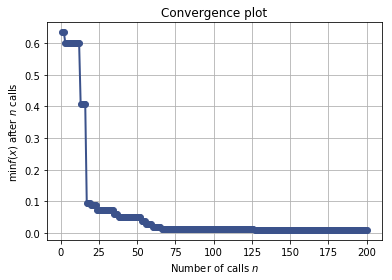

In [11]:
res_gp = skopt.load('build/res_gp_icorr_lda_unif.pkl')
plot_convergence(res_gp)

In [12]:
print(res_gp.x, res_gp.fun)

[36, 426.7508971574705, 13.71783036833933, 0.01, 21.94511087602356, 0.34693510901066477, 1000.0] 0.009398705206343396


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943    1451  113463  0.082923
item popularity stats
           ml_100k          lda
count  1682.000000  1451.000000
mean     59.453032    78.196416
std      80.383846    87.739713
min       1.000000     1.000000
25%       6.000000    11.000000
50%      27.000000    42.000000
75%      80.000000   119.000000
max     583.000000   374.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539  120.321315
std    100.931743   98.512168
min     20.000000   22.000000
25%     33.000000   37.000000
50%     65.000000   77.000000
75%    148.000000  210.000000
max    737.000000  319.000000


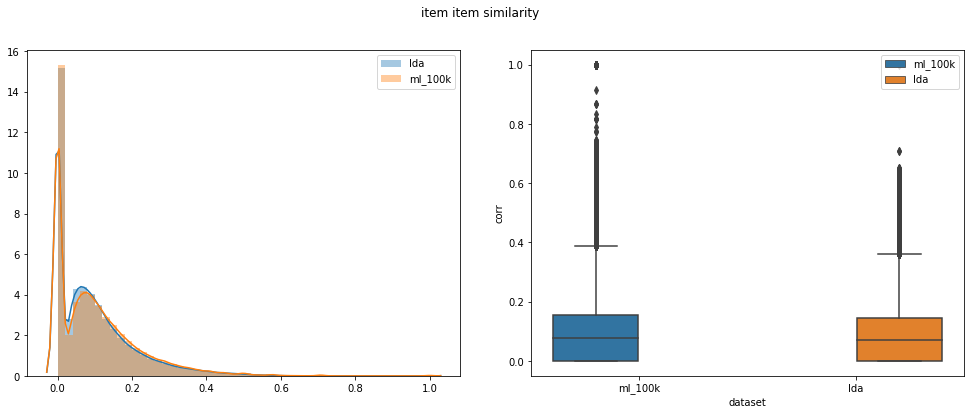

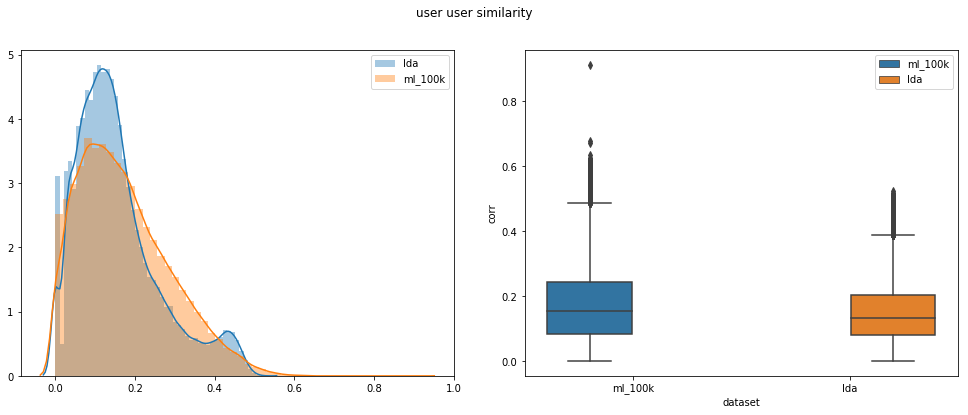

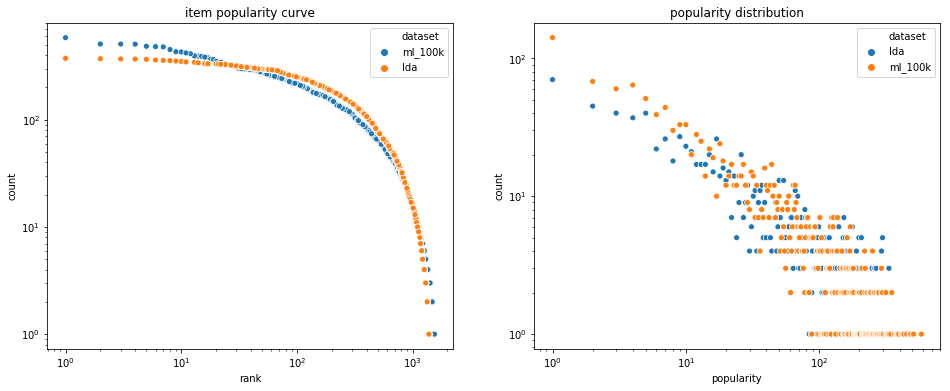

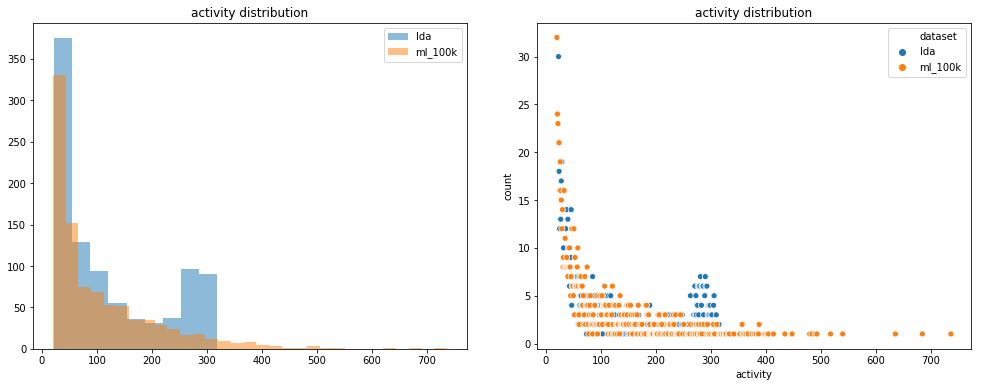

In [13]:
plot_stats(('ml_100k', ml_100k), ('lda', lda_unif_pareto), args=[943, 1682, *res_gp.x])

### lda unif on user user similarity

It seems that computing metric for a single run is better to find good parameters for lda unif model than using the mean of multiple runs.

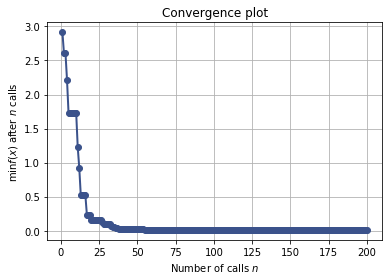

In [14]:
res_gp = skopt.load('build/res_gp_ucorr_lda_unif.pkl')
plot_convergence(res_gp)

In [15]:
print(res_gp.x, res_gp.fun)

[10, 356.9281322082611, 0.1320310199264947, 0.01, 24.54479699573428, 0.3807412139981881, 644.625054327646] 0.011110129433962277


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943     855   68901  0.085457
item popularity stats
           ml_100k         lda
count  1682.000000  855.000000
mean     59.453032   80.585965
std      80.383846   83.327332
min       1.000000    1.000000
25%       6.000000    9.000000
50%      27.000000   47.000000
75%      80.000000  133.000000
max     583.000000  412.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539   73.065748
std    100.931743   34.518986
min     20.000000   24.000000
25%     33.000000   40.000000
50%     65.000000   72.000000
75%    148.000000  101.000000
max    737.000000  176.000000


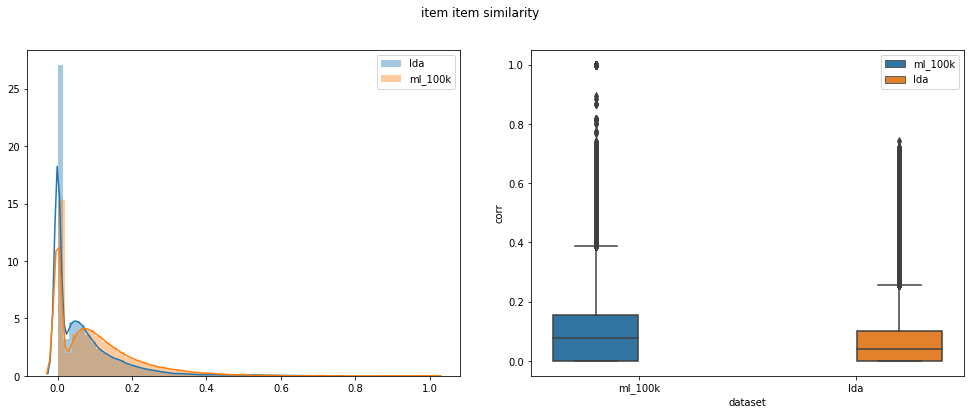

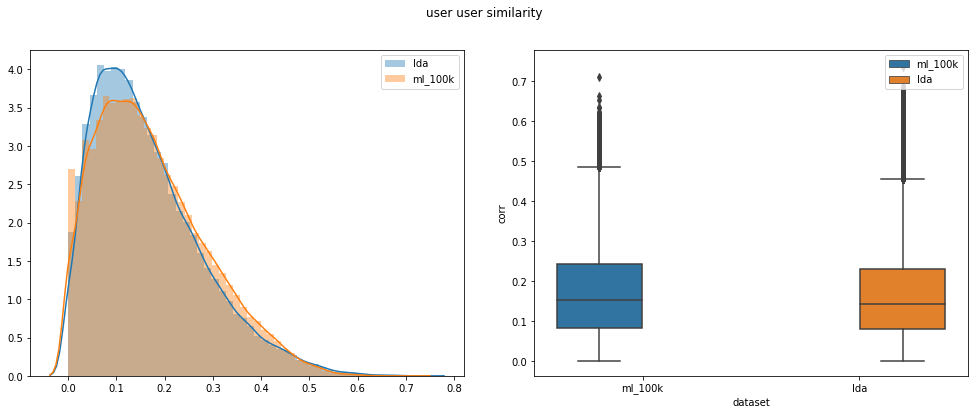

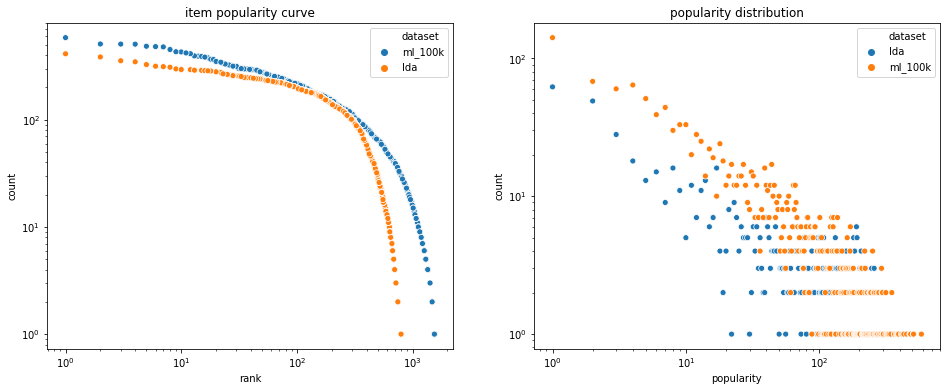

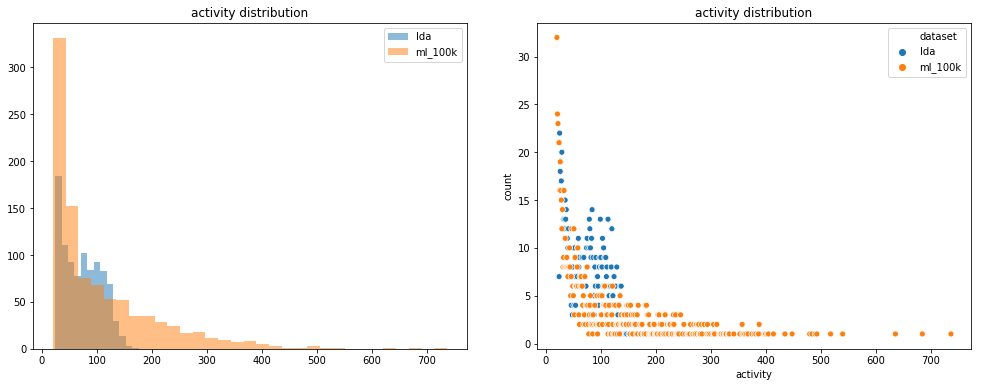

In [16]:
plot_stats(('ml_100k', ml_100k), ('lda', lda_unif_pareto), args=[943, 1682, *res_gp.x])

### lda unif on item popularity

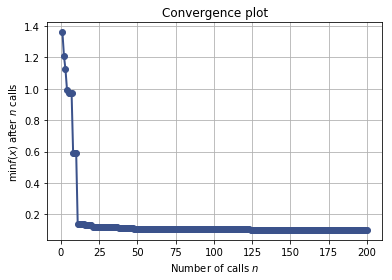

In [17]:
res_gp = skopt.load('build/res_gp_item_pop_lda_unif.pkl')
plot_convergence(res_gp)

In [18]:
print(res_gp.x, res_gp.fun)

[10, 33.523483092633, 0.01, 0.01, 19.430589057226427, 74.77151513318162, 315.66470081709537] 0.10065202909715174


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943     685   16649  0.025774
item popularity stats
           ml_100k         lda
count  1682.000000  685.000000
mean     59.453032   24.305109
std      80.383846   31.470659
min       1.000000    1.000000
25%       6.000000    2.000000
50%      27.000000   11.000000
75%      80.000000   33.000000
max     583.000000  273.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539   17.655355
std    100.931743    1.885522
min     20.000000   10.000000
25%     33.000000   17.000000
50%     65.000000   19.000000
75%    148.000000   19.000000
max    737.000000   21.000000


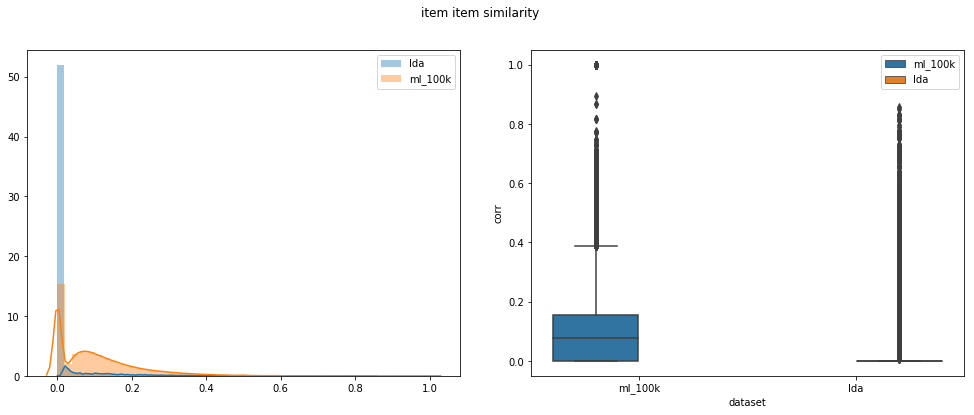

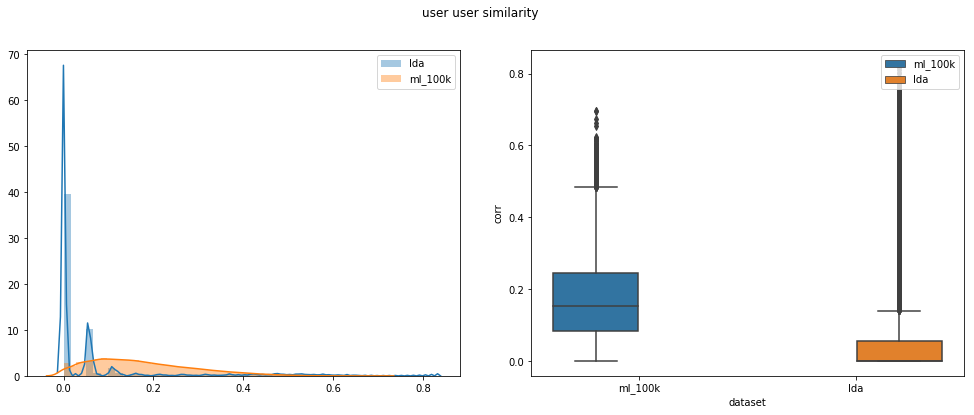

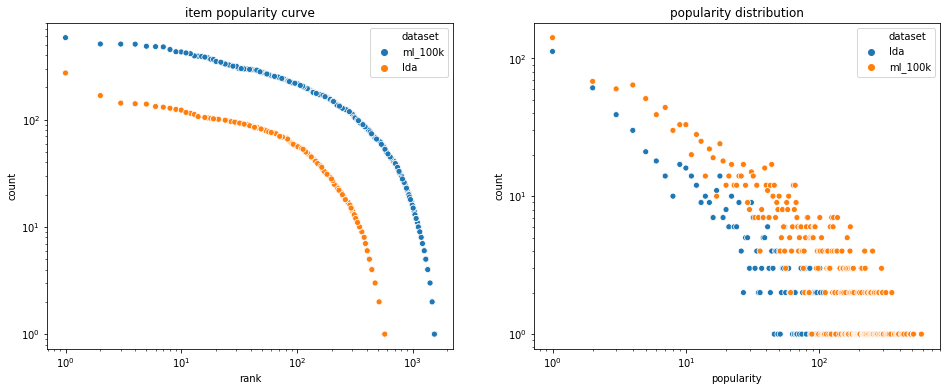

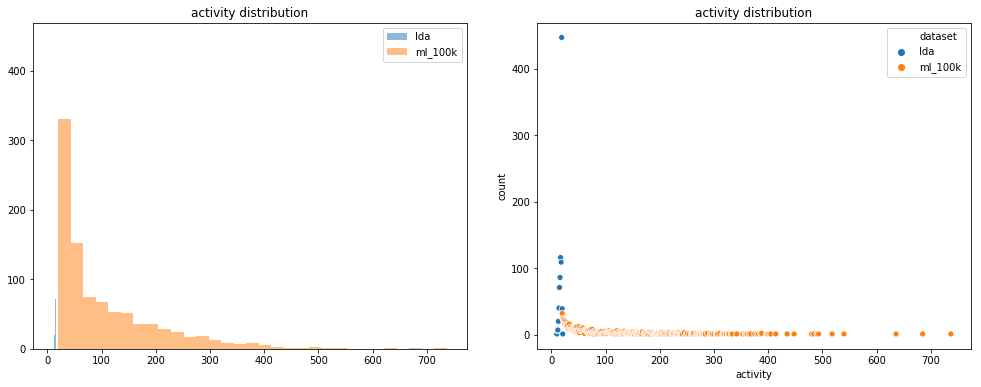

In [19]:
plot_stats(('ml_100k', ml_100k), ('lda', lda_unif_pareto), args=[943, 1682, *res_gp.x])

### lda unif on user activity

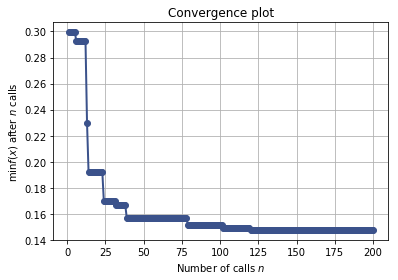

In [20]:
res_gp = skopt.load('build/res_gp_user_act_lda_unif.pkl')
plot_convergence(res_gp)

In [21]:
print(res_gp.x, res_gp.fun)

[500, 464.77666259223537, 0.07714121880981595, 1000.0, 20.186015735617644, 0.5095639312537547, 340.039611081204] 0.14764040996777333


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943    1682   77661  0.048963
item popularity stats
           ml_100k          lda
count  1682.000000  1682.000000
mean     59.453032    46.171819
std      80.383846     6.564889
min       1.000000    26.000000
25%       6.000000    42.000000
50%      27.000000    46.000000
75%      80.000000    51.000000
max     583.000000    70.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539   82.355249
std    100.931743   73.352275
min     20.000000   20.000000
25%     33.000000   31.000000
50%     65.000000   53.000000
75%    148.000000  108.500000
max    737.000000  336.000000


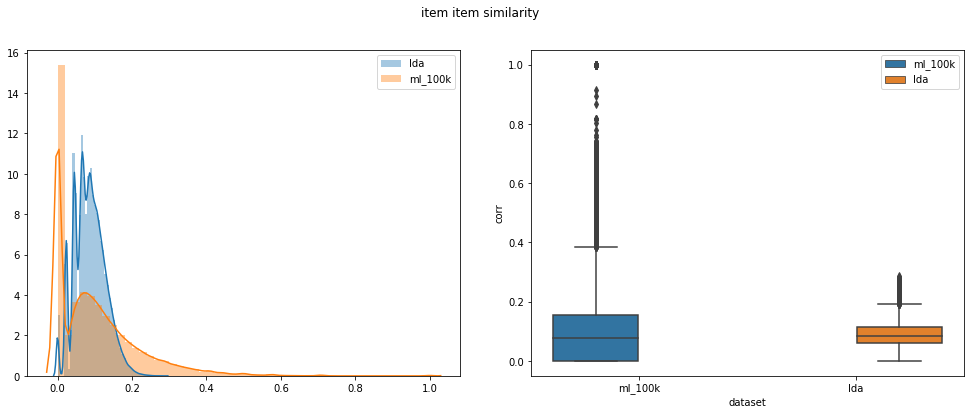

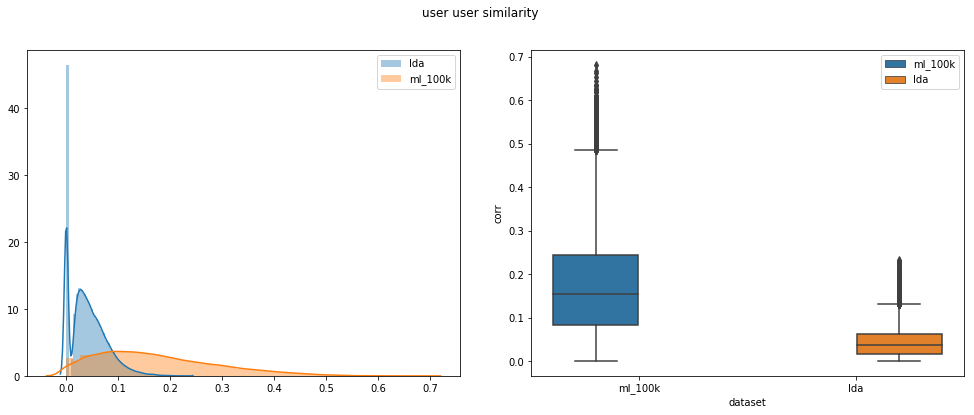

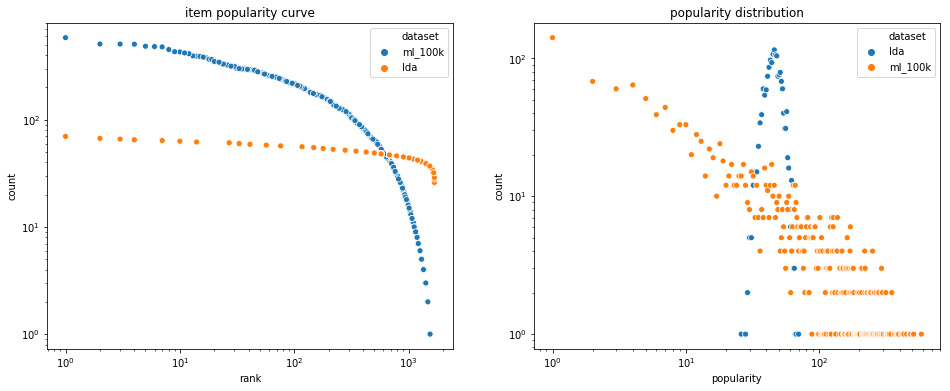

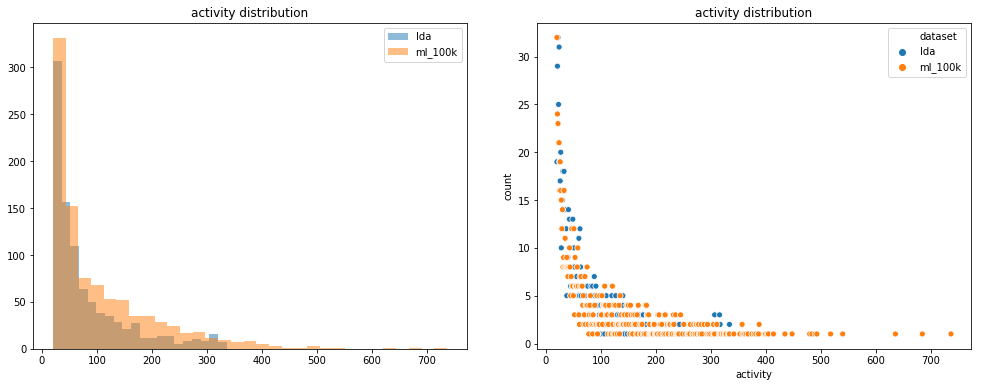

In [22]:
plot_stats(('ml_100k', ml_100k), ('lda', lda_unif_pareto), args=[943, 1682, *res_gp.x])

### lda unif on the linear combination of all metrics.

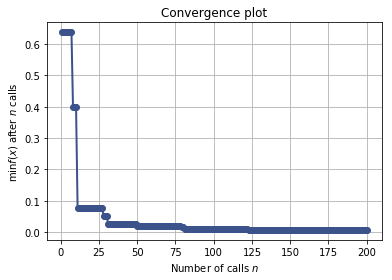

In [37]:
res_gp = skopt.load('build/res_gp_icorr_lda_pop.pkl')
plot_convergence(res_gp)

In [38]:
print(res_gp.x, res_gp.fun)

[37, 397.75273525897956, 24.505854632716282, 0.01, 30.0, 0.1, 455.02024852467423] 0.006900005338903295


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943    1473  128989  0.092862
item popularity stats
           ml_100k          lda
count  1682.000000  1473.000000
mean     59.453032    87.568907
std      80.383846    95.517950
min       1.000000     1.000000
25%       6.000000    12.000000
50%      27.000000    52.000000
75%      80.000000   135.000000
max     583.000000   426.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539  136.785790
std    100.931743   87.886572
min     20.000000   30.000000
25%     33.000000   57.500000
50%     65.000000  111.000000
75%    148.000000  212.000000
max    737.000000  317.000000


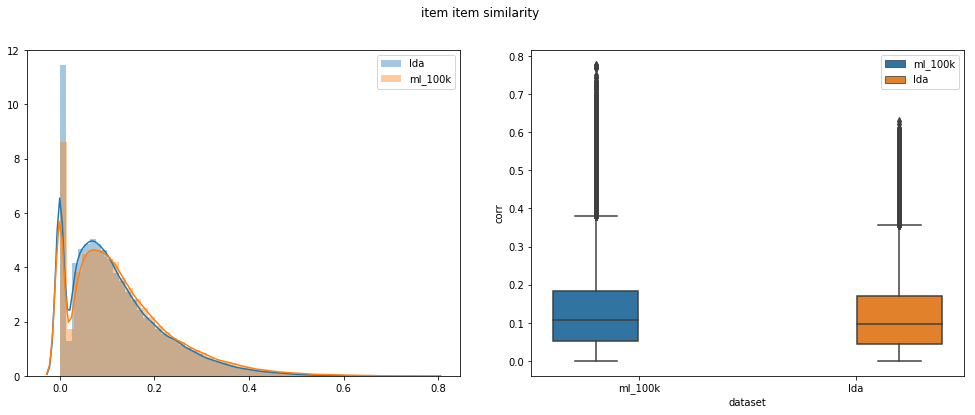

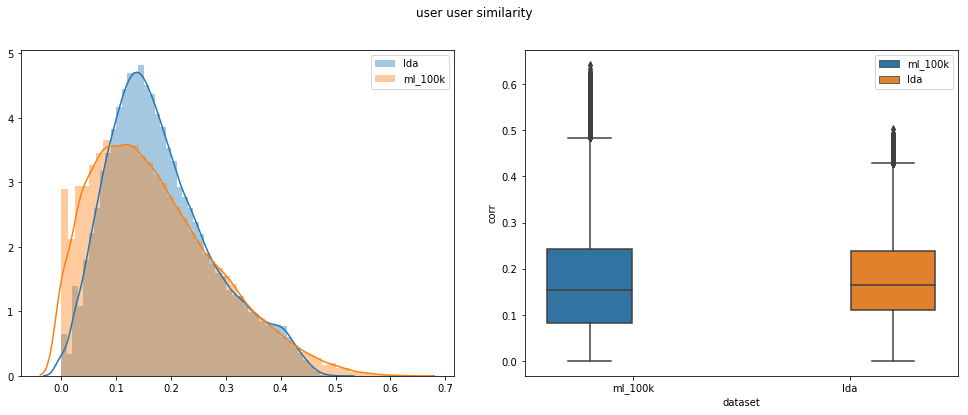

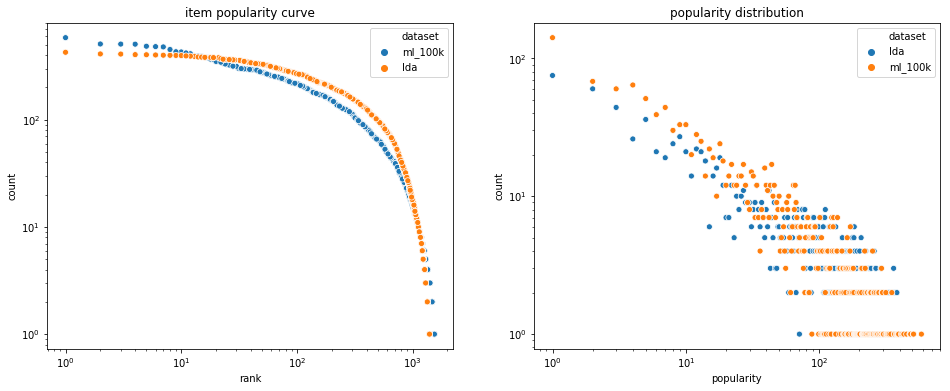

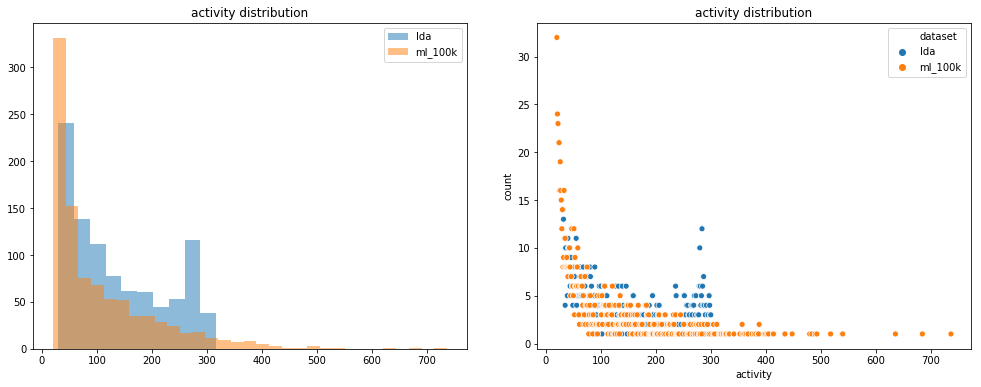

In [41]:
plot_stats(('ml_100k', ml_100k), ('lda', lda_unif_pareto), args=[943, 1682, *res_gp.x], mrated=5)

### lda Pop on item-item similarity

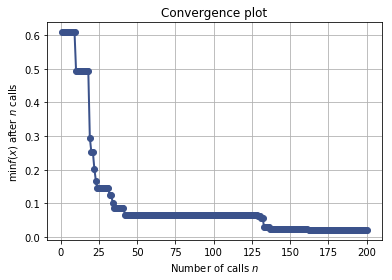

In [45]:
res_gp = skopt.load('build/res_gp_icorr_lda_pop.pkl')
plot_convergence(res_gp)

In [46]:
print(res_gp.x, res_gp.fun)

[10, 689.6050145811279, 1000.0, 0.1, 15.421940527981903, 0.1, 403.9350804359551] 0.021156438268773142


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943    1543  103935  0.071431
item popularity stats
           ml_100k          lda
count  1682.000000  1543.000000
mean     59.453032    67.359041
std      80.383846    70.435559
min       1.000000     1.000000
25%       6.000000    12.000000
50%      27.000000    42.000000
75%      80.000000   103.000000
max     583.000000   336.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539  110.217391
std    100.931743  101.544654
min     20.000000   15.000000
25%     33.000000   31.000000
50%     65.000000   67.000000
75%    148.000000  163.500000
max    737.000000  402.000000


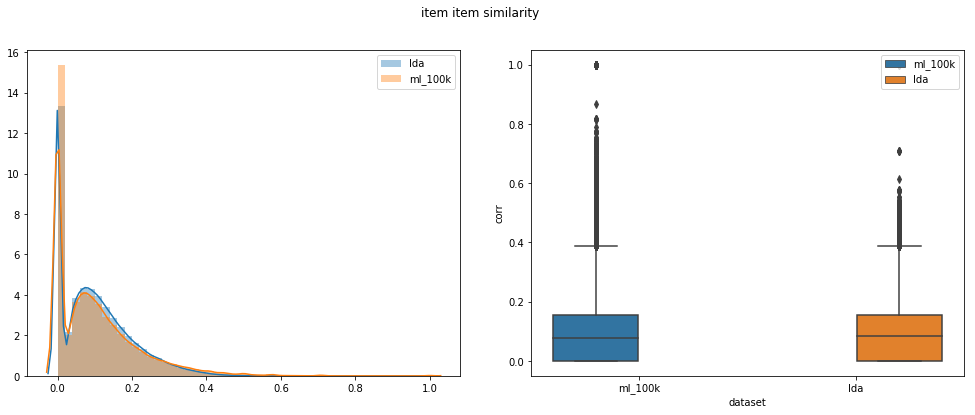

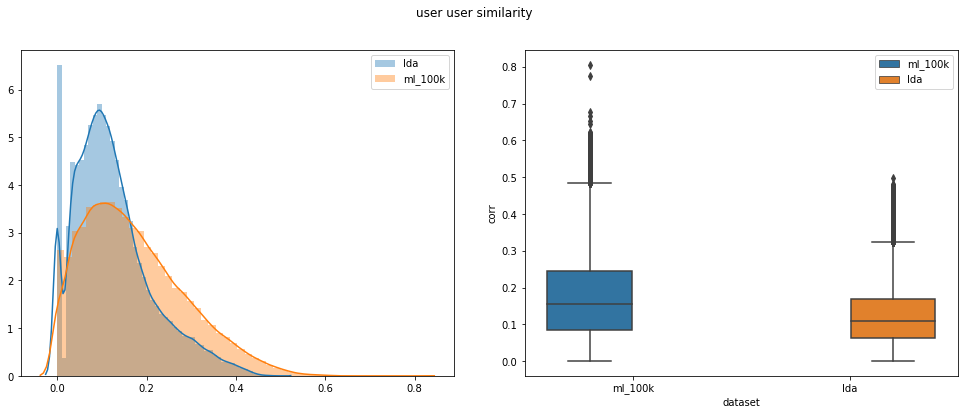

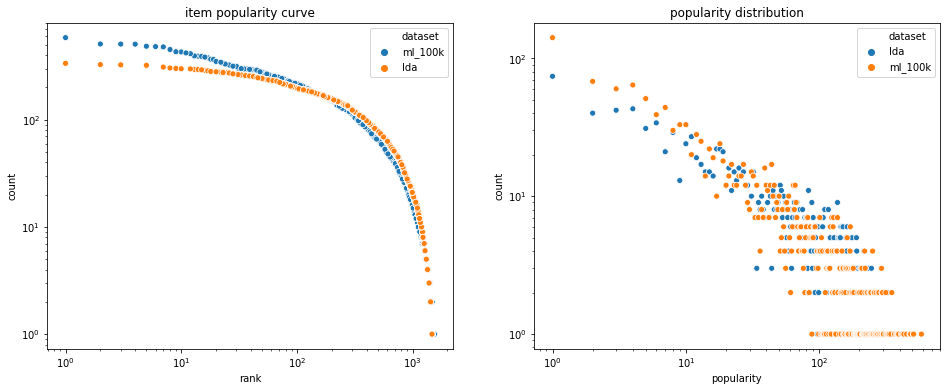

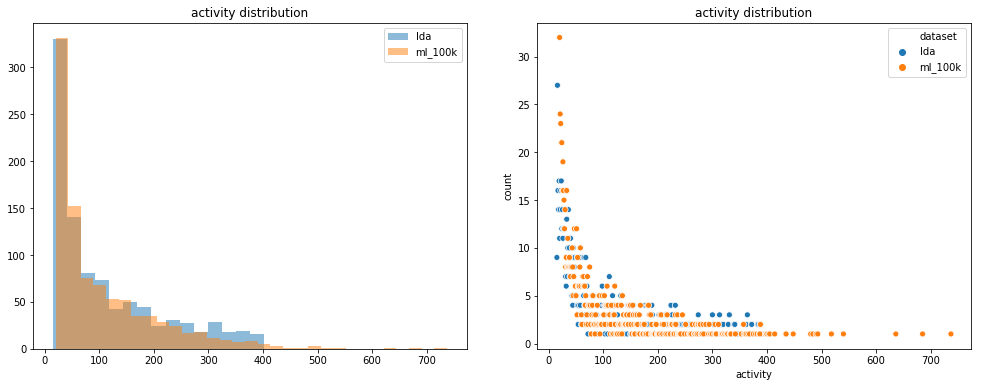

In [47]:
idx = np.fromiter(range(0, len(res_gp.x_iters), len(res_gp.x_iters) // 1), dtype=np.int)

for i in np.argsort(res_gp.func_vals)[idx]:
    plot_stats(('ml_100k', ml_100k), ('lda', lda_pop_pareto), args=[943, 1682, *res_gp.x_iters[i]])

### lda pop on user user similarity

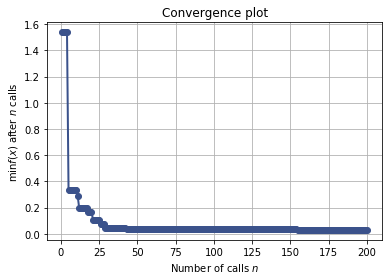

In [48]:
res_gp = skopt.load('build/gp_minimize_lda_pop-ml_100k-ucorr-1-2019-03-26-15-01-43.pkl')
plot_convergence(res_gp)

In [49]:
print(res_gp.x, res_gp.fun)

[66, 801.8552394276803, 8.578092692834458, 0.01, 18.0, 0.1, 548.9611775819028] 0.02938102426187242


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943    1491  133913  0.095243
item popularity stats
           ml_100k          lda
count  1682.000000  1491.000000
mean     59.453032    89.814219
std      80.383846    91.636463
min       1.000000     1.000000
25%       6.000000    14.500000
50%      27.000000    56.000000
75%      80.000000   136.500000
max     583.000000   390.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539  142.007423
std    100.931743  135.307501
min     20.000000   18.000000
25%     33.000000   38.000000
50%     65.000000   89.000000
75%    148.000000  204.500000
max    737.000000  535.000000


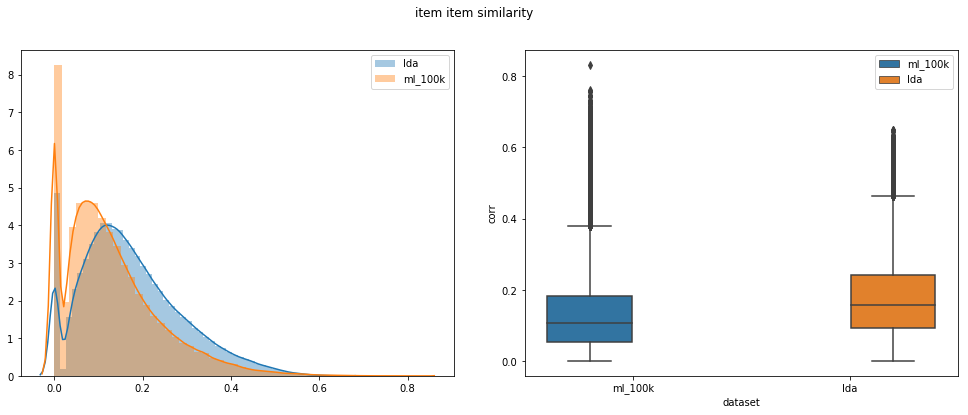

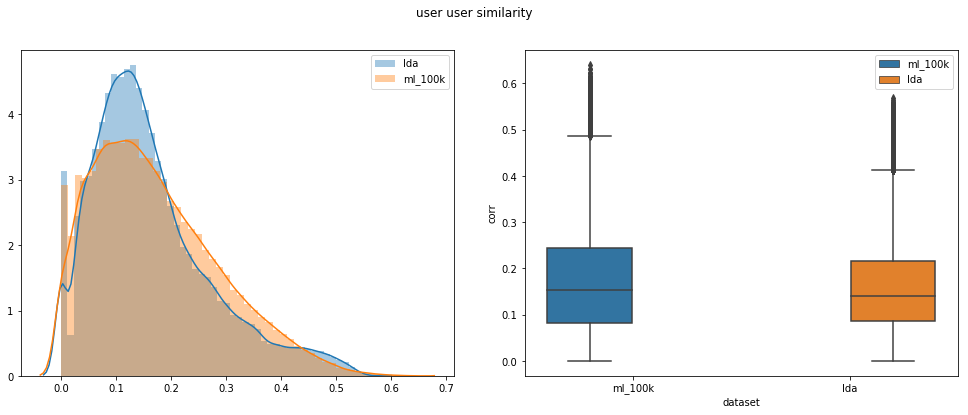

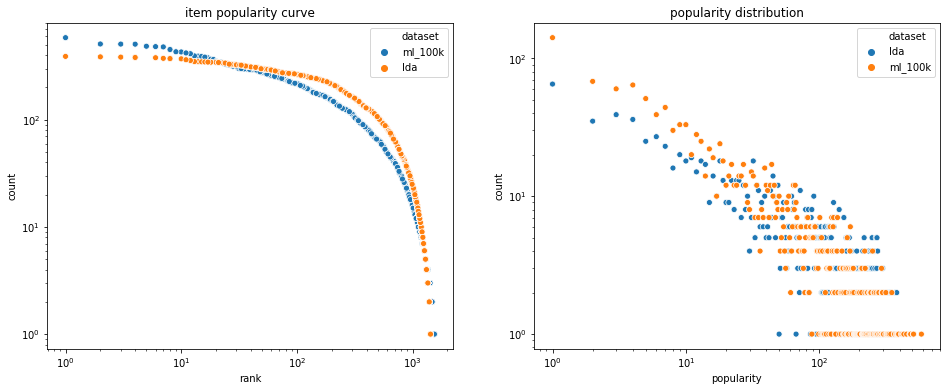

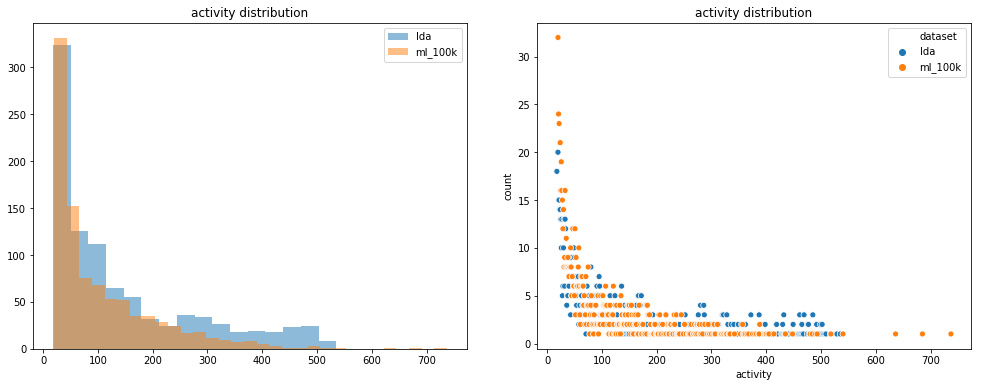

In [50]:
idx = np.fromiter(range(0, len(res_gp.x_iters), len(res_gp.x_iters) // 1), dtype=np.int)

for i in np.argsort(res_gp.func_vals)[idx]:
    plot_stats(('ml_100k', ml_100k), ('lda', lda_pop_pareto), args=[943, 1682, *res_gp.x_iters[i]], mrated=5)

### lda pop on item popularity

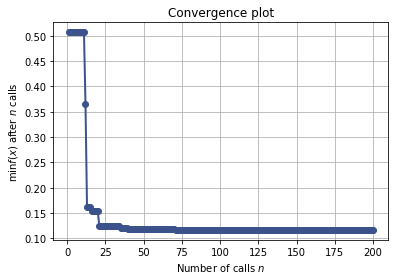

In [71]:
res_gp = skopt.load('build/res_gp_item_pop_lda_pop.pkl')
plot_convergence(res_gp)

In [72]:
print(res_gp.fun, res_gp.x)

0.11655606076732958 [10, 100.0, 1000.0, 0.1, 30.0, 0.1, 100.0]


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943    1518   53853  0.037621
item popularity stats
           ml_100k          lda
count  1682.000000  1518.000000
mean     59.453032    35.476285
std      80.383846    42.280888
min       1.000000     1.000000
25%       6.000000     7.000000
50%      27.000000    20.000000
75%      80.000000    48.000000
max     583.000000   361.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539   57.108165
std    100.931743   20.067428
min     20.000000   30.000000
25%     33.000000   39.000000
50%     65.000000   54.000000
75%    148.000000   74.000000
max    737.000000   99.000000


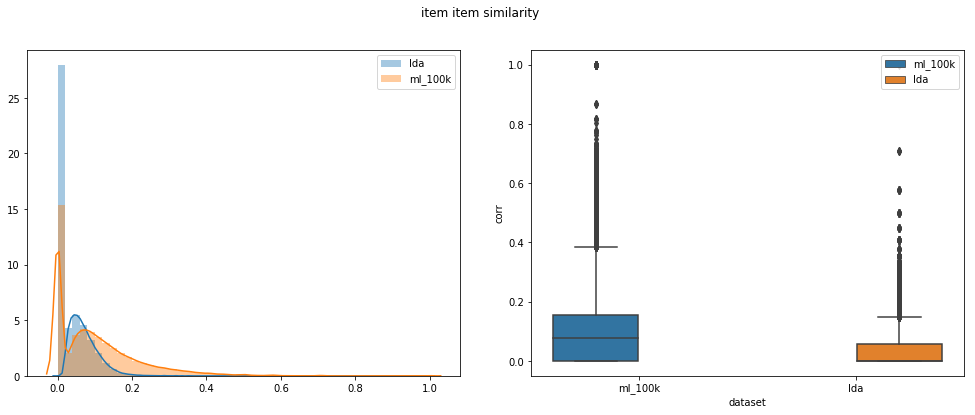

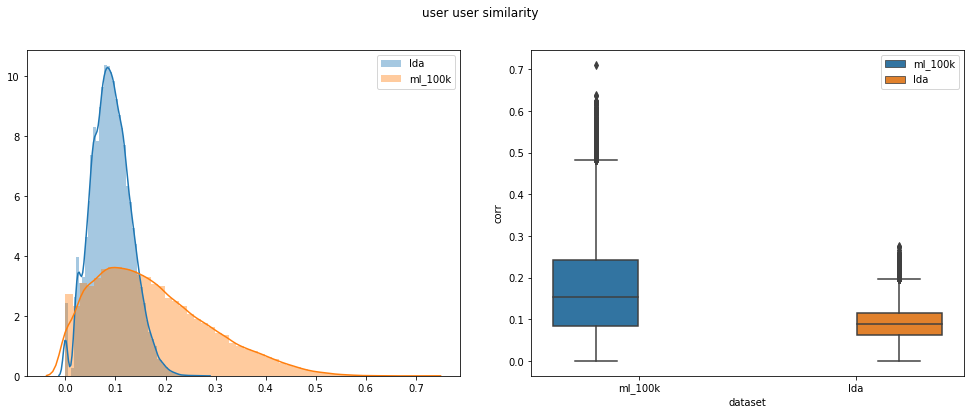

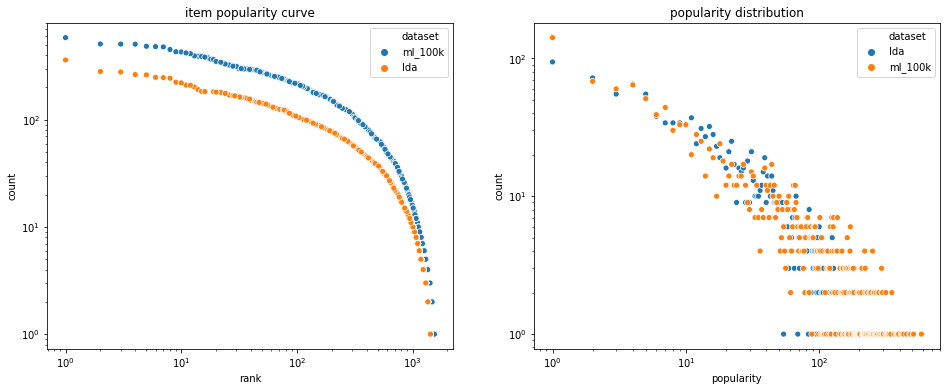

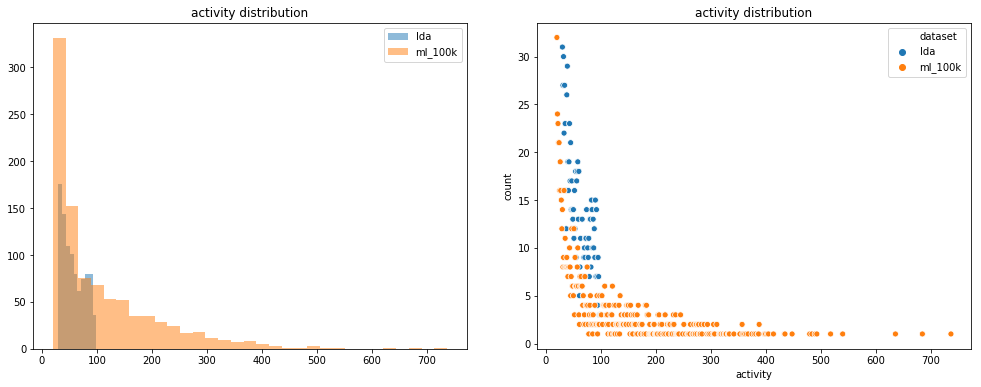

In [73]:
plot_stats(('ml_100k', ml_100k), ('lda', lda_pop_pareto), args=[943, 1682, *res_gp.x], mrated=1)

### lda pop on user activity

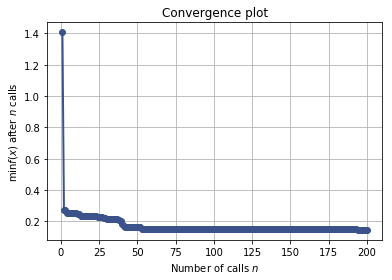

In [74]:
res_gp = skopt.load('build/res_gp_user_act_lda_pop.pkl')
plot_convergence(res_gp)

In [76]:
print(res_gp.fun, res_gp.x)

0.1460967118505485 [41, 1462.062205346758, 1000.0, 1000.0, 20.01867476686278, 0.3523234475533948, 335.14178770777073]


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943    1682   85042  0.053616
item popularity stats
           ml_100k          lda
count  1682.000000  1682.000000
mean     59.453032    50.560048
std      80.383846     7.185667
min       1.000000    21.000000
25%       6.000000    46.000000
50%      27.000000    51.000000
75%      80.000000    55.000000
max     583.000000    77.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539   90.182397
std    100.931743   78.783119
min     20.000000   20.000000
25%     33.000000   32.000000
50%     65.000000   55.000000
75%    148.000000  126.000000
max    737.000000  334.000000


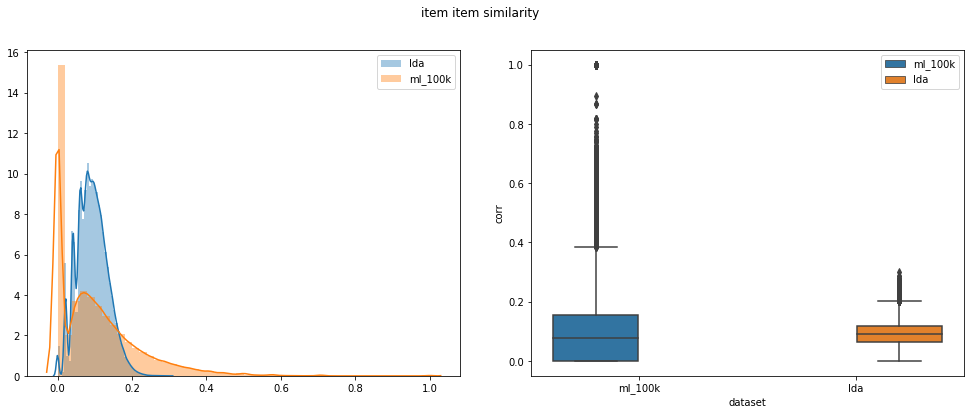

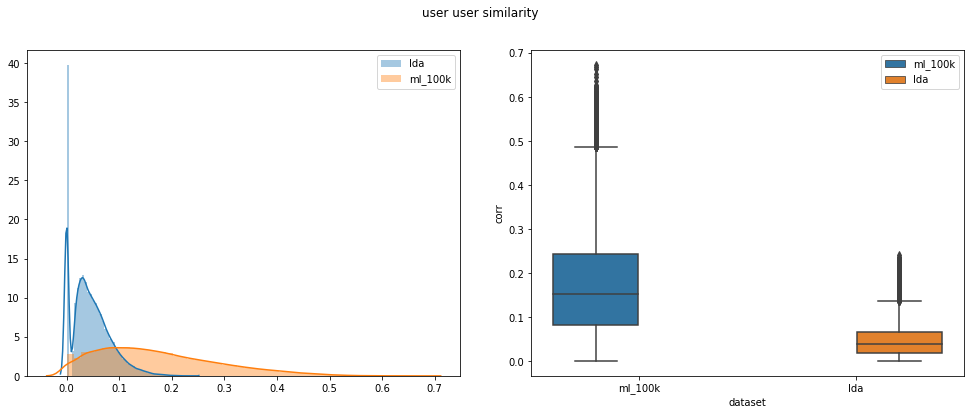

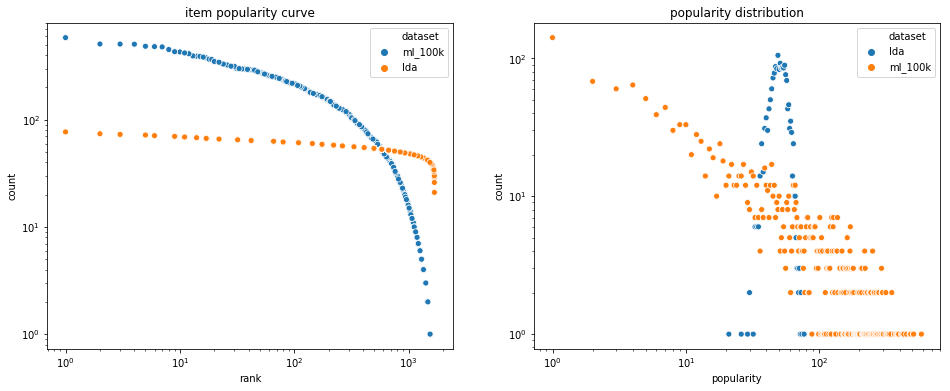

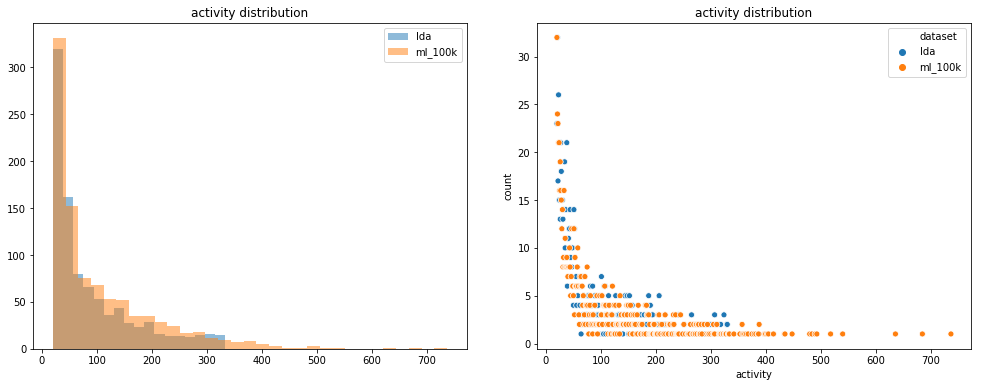

In [75]:
plot_stats(('ml_100k', ml_100k), ('lda', lda_pop_pareto), args=[943, 1682, *res_gp.x], mrated=1)

### lda pop on a linear combination of all metrics

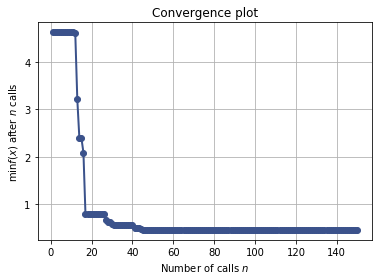

In [77]:
res_gp = skopt.load('build/gp_minimize_lda_pop-ml_100k-all-2019-03-24-16-23-53')
plot_convergence(res_gp)

In [78]:
print(res_gp.fun, res_gp.x)

0.4524857696905369 [10, 608.9467064207421, 8.945170351208025, 0.1, 19.97785909473361, 0.1, 400.0]


dataset stats
   dataset  nusers  nitems  npairs   density
0  ml_100k     943    1682  100000  0.063047
1      lda     943    1546  115082  0.078938
item popularity stats
           ml_100k          lda
count  1682.000000  1546.000000
mean     59.453032    74.438551
std      80.383846    79.519791
min       1.000000     1.000000
25%       6.000000    14.000000
50%      27.000000    44.000000
75%      80.000000   110.000000
max     583.000000   433.000000
user profile stats
          ml_100k         lda
count  943.000000  943.000000
mean   106.044539  122.038176
std    100.931743  101.787019
min     20.000000   19.000000
25%     33.000000   37.500000
50%     65.000000   85.000000
75%    148.000000  182.000000
max    737.000000  396.000000


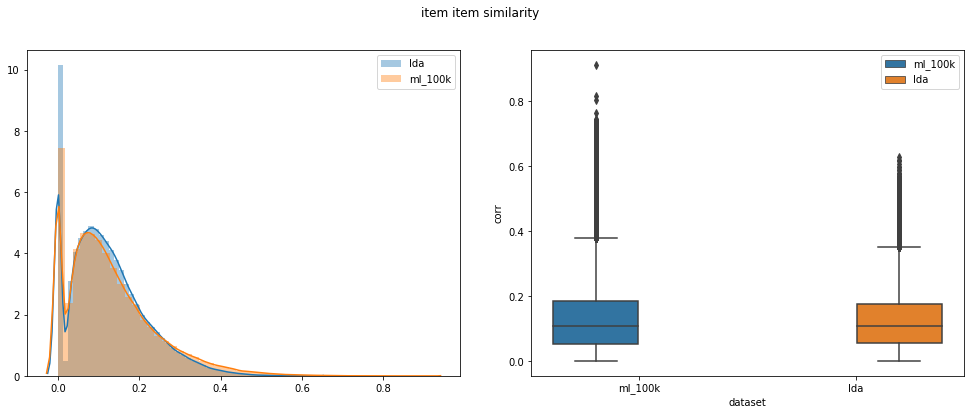

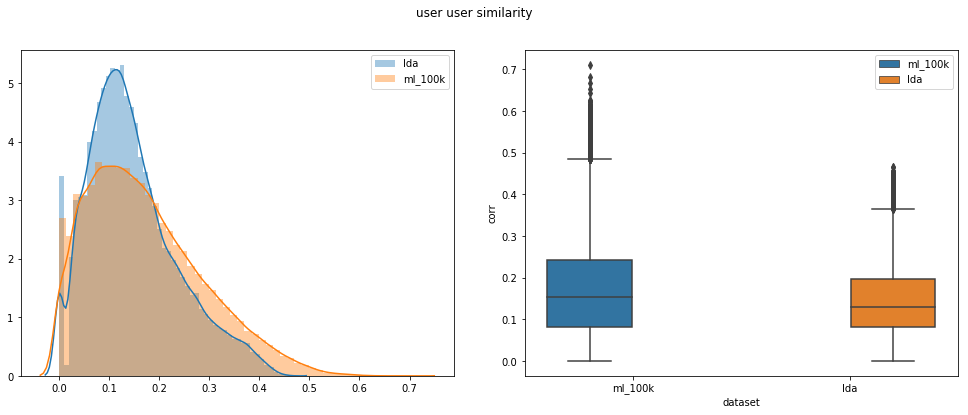

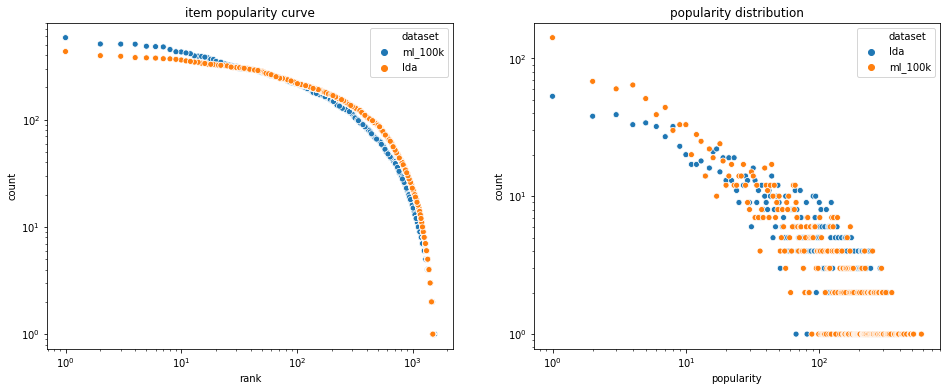

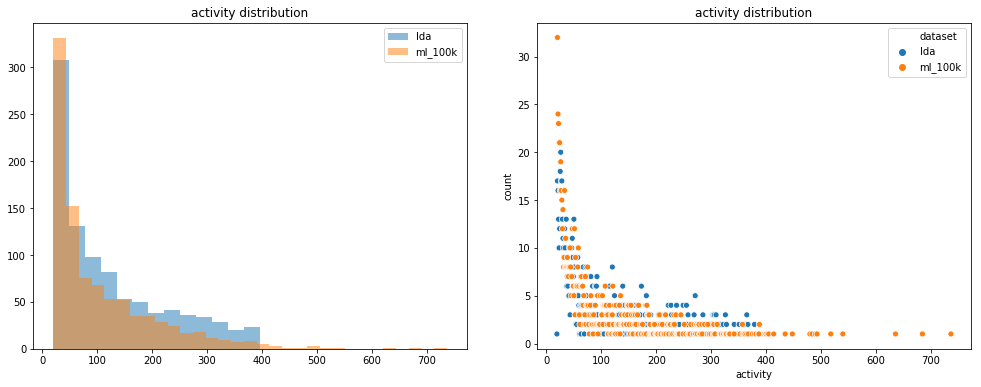

In [79]:
plot_stats(('ml_100k', ml_100k), ('lda', lda_pop_pareto), args=[943, 1682, *res_gp.x], mrated=5)

## ML 1M

### lda unif on user user

[80, 886.6049003566645, 10.0, 0.01, 16.0, 0.1, 2526.4498977780213] 0.18426626332145077
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3685  1682059  0.075573
item popularity stats
              ml1m          lda
count  3706.000000  3685.000000
mean    269.889099   456.461058
std     384.047838   415.722888
min       1.000000     1.000000
25%      33.000000   128.000000
50%     123.500000   331.000000
75%     350.000000   676.000000
max    3428.000000  2238.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517   278.486589
std     192.747029   264.119186
min      20.000000    16.000000
25%      44.000000    45.000000
50%      96.000000   153.000000
75%     208.000000   568.250000
max    2314.000000   760.000000


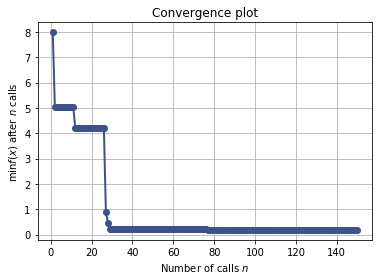

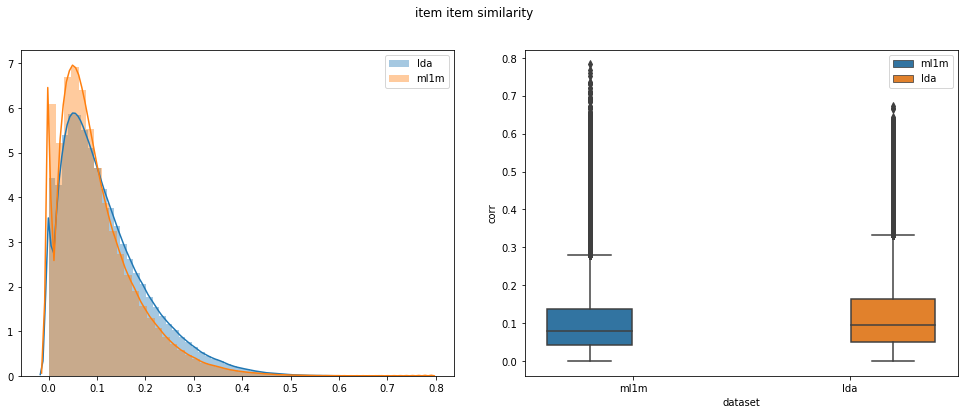

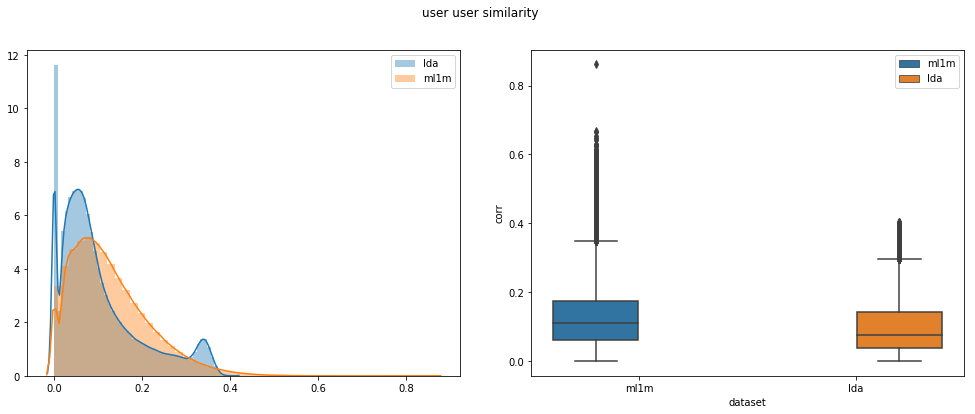

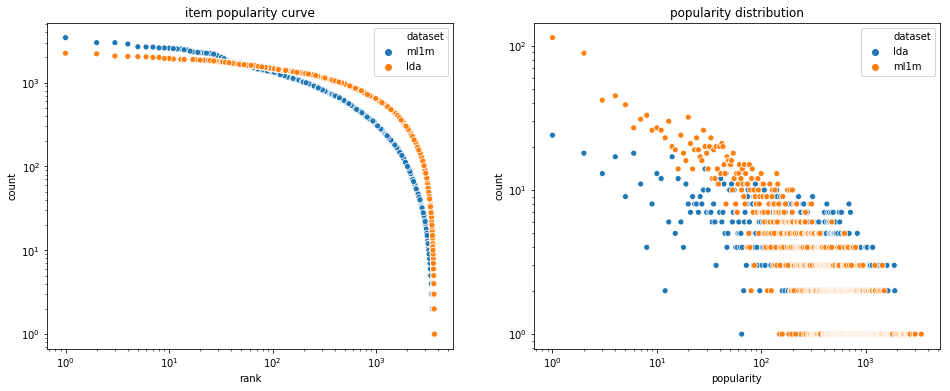

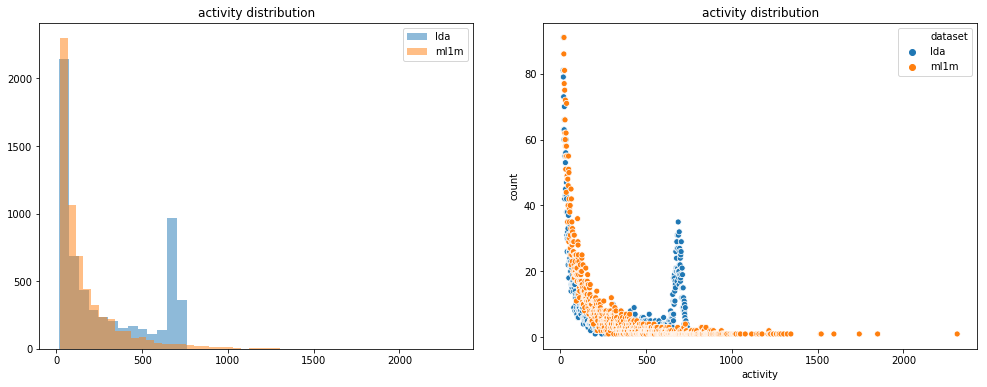

In [11]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-ml_1m-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-ml_1m-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif_csr-ml_1m-ucorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data), mrated=5)

### lda unif on item item

[47, 1253.8402646537493, 10.0, 0.01, 21.498141401157255, 0.6471269058116557, 2605.7595291477396] 0.015682427594223718
simulated data is used
dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3547   899921  0.042006
item popularity stats
              ml1m          lda
count  3706.000000  3547.000000
mean    269.889099   253.713279
std     384.047838   256.651484
min       1.000000     1.000000
25%      33.000000    41.000000
50%     123.500000   161.000000
75%     350.000000   400.000000
max    3428.000000  1077.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517   148.993543
std     192.747029   210.502674
min      20.000000    21.000000
25%      44.000000    32.000000
50%      96.000000    57.000000
75%     208.000000   147.000000
max    2314.000000   881.000000


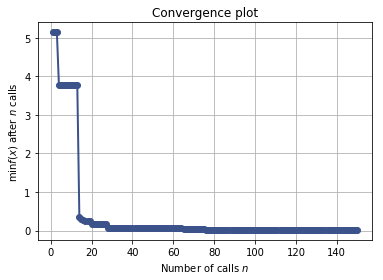

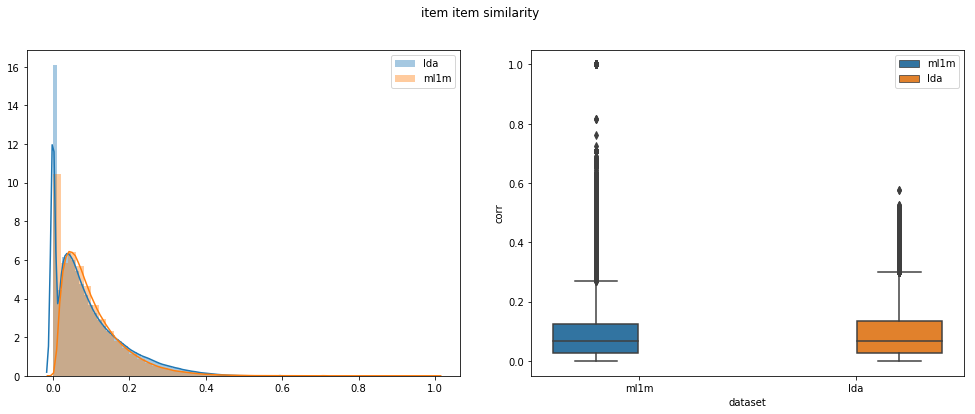

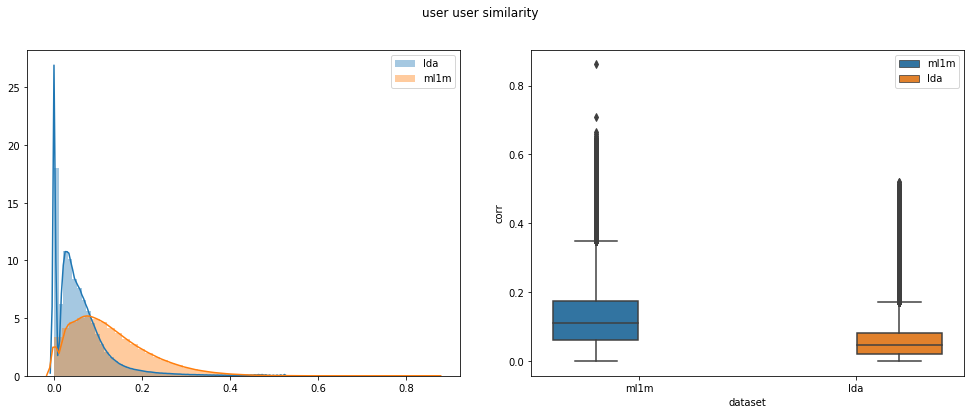

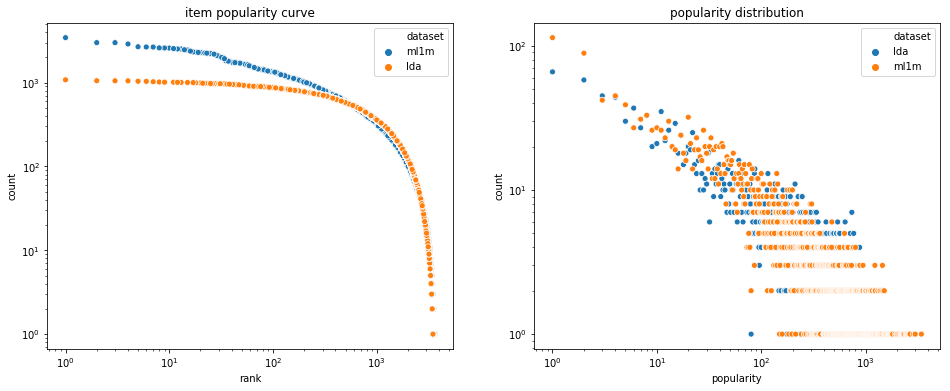

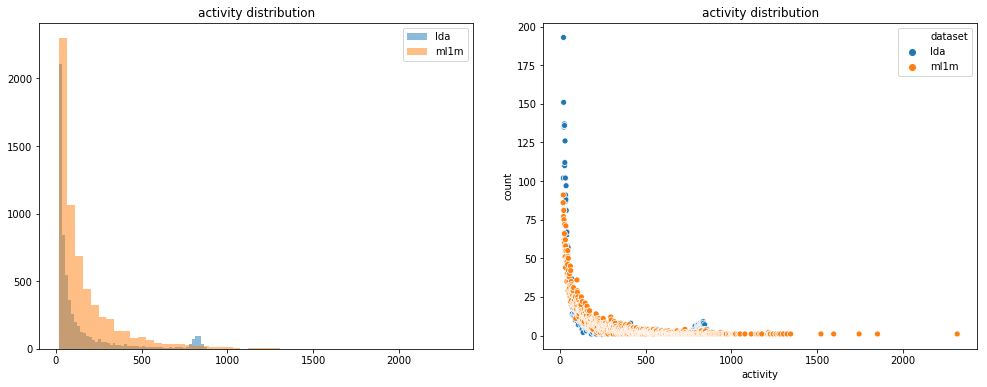

In [12]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-ml_1m-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-ml_1m-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif_csr-ml_1m-icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda unif on item pop

[71, 232.20417082649425, 8.319982050627207, 0.01, 17.22384009655272, 0.1, 1851.2] 0.3964071078000226
simulated data is used
dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3627   786237  0.035890
item popularity stats
              ml1m          lda
count  3706.000000  3627.000000
mean    269.889099   216.773366
std     384.047838   232.609631
min       1.000000     1.000000
25%      33.000000    46.000000
50%     123.500000   139.000000
75%     350.000000   306.500000
max    3428.000000  1742.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517   130.171689
std     192.747029    81.113050
min      20.000000    17.000000
25%      44.000000    45.000000
50%      96.000000   134.000000
75%     208.000000   211.000000
max    2314.000000   262.000000


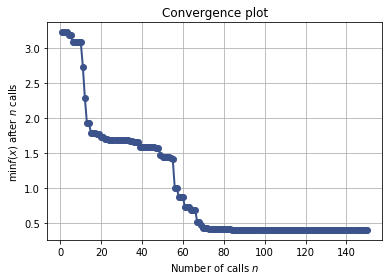

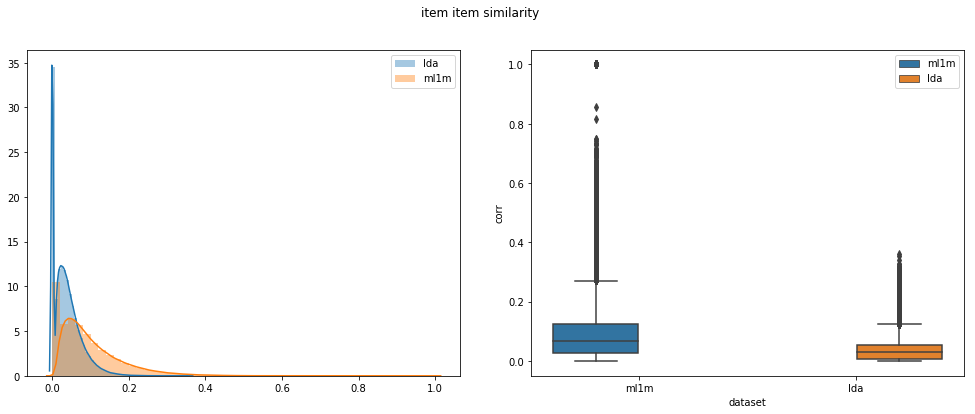

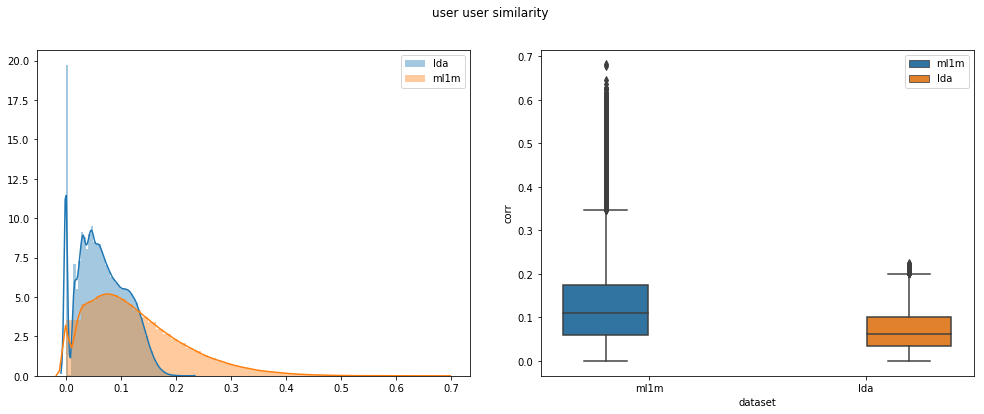

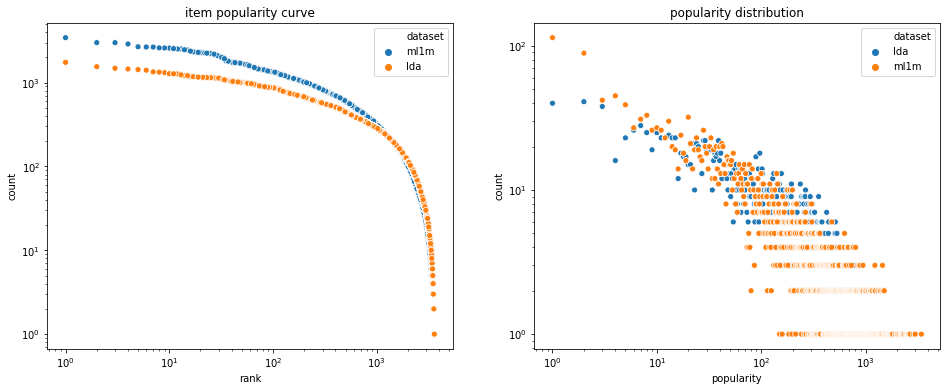

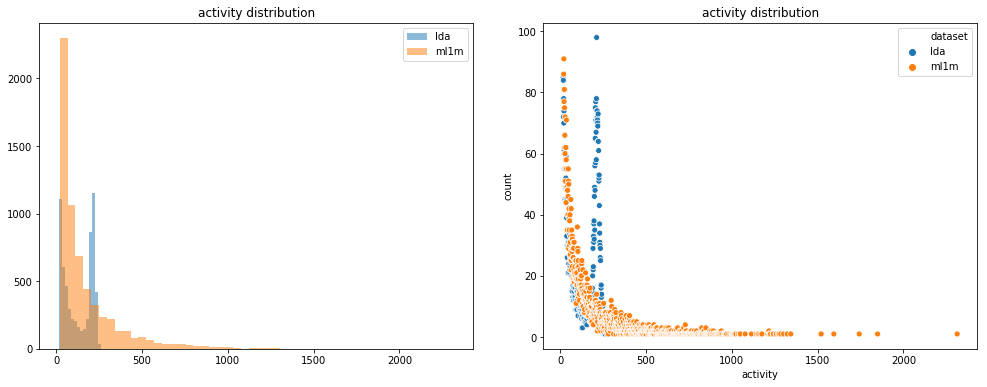

In [14]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-ml_1m-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-ml_1m-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif_csr-ml_1m-item-pop.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda unif on user activity

[39, 200.0, 0.01, 8.176490970305586, 20.320509997504175, 0.1, 281.4864675840416] 0.6786455675602059
simulated data is used


/home/mtian/IdeaProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3706   536251  0.023957
item popularity stats
              ml1m          lda
count  3706.000000  3706.000000
mean    269.889099   144.698057
std     384.047838    14.407536
min       1.000000    96.000000
25%      33.000000   135.000000
50%     123.500000   145.000000
75%     350.000000   154.000000
max    3428.000000   210.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517    88.783278
std     192.747029    59.605500
min      20.000000    20.000000
25%      44.000000    37.000000
50%      96.000000    69.000000
75%     208.000000   137.000000
max    2314.000000   228.000000


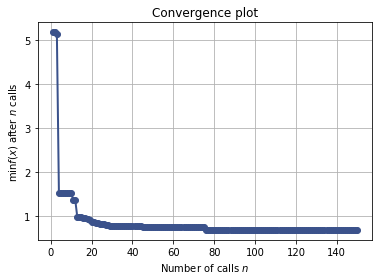

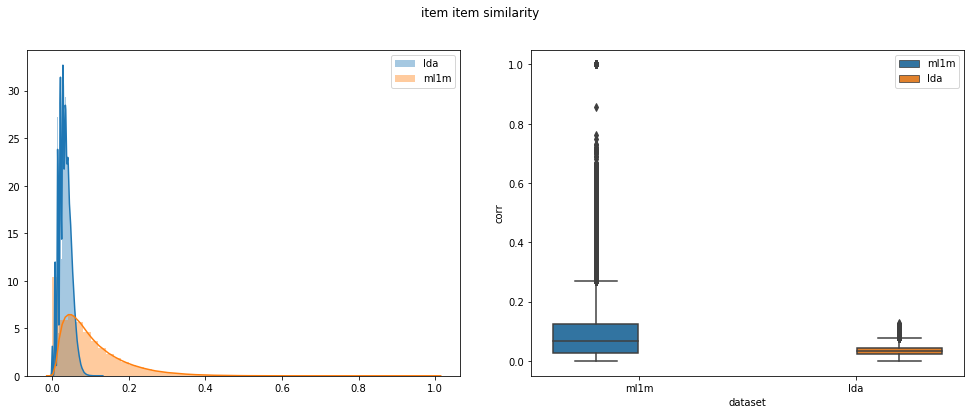

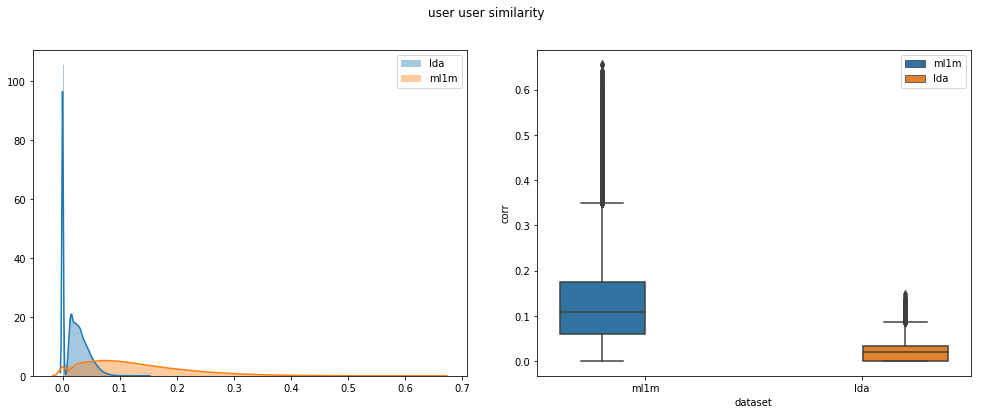

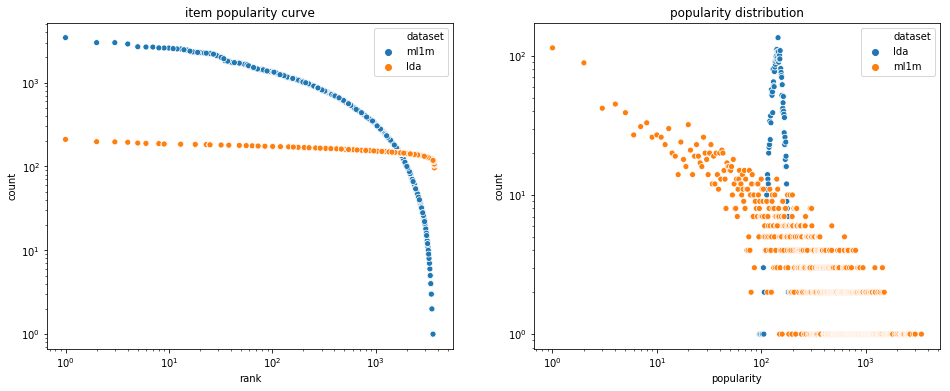

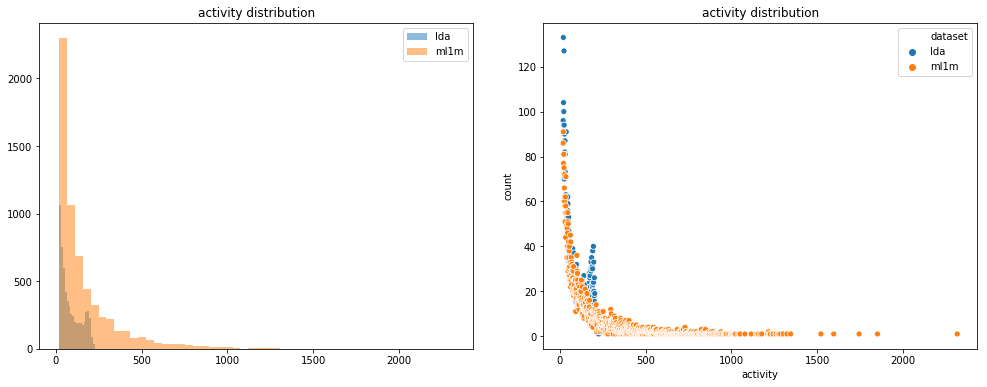

In [19]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-ml_1m-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-ml_1m-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif_csr-ml_1m-user-act.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda unif on all

[59, 499.99999999999994, 1.0, 0.01, 20.556766617347243, 0.2609592818898593, 1851.2] 0.849475244898058
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


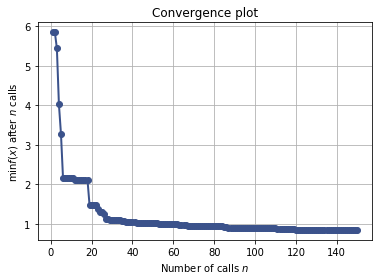

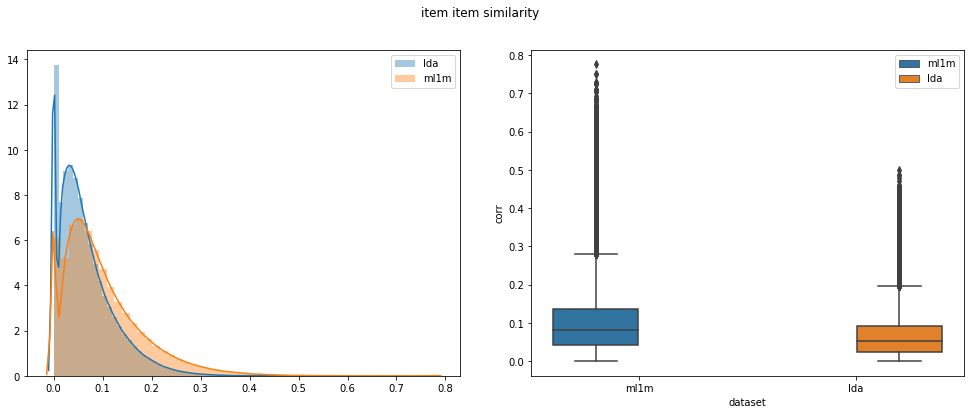

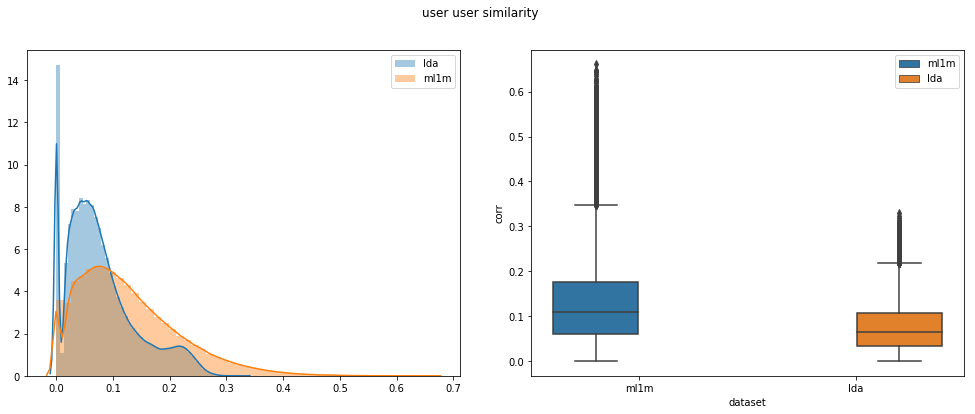

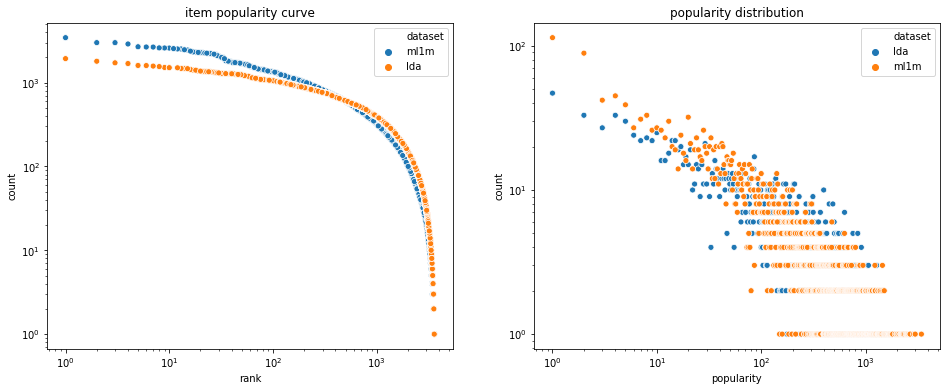

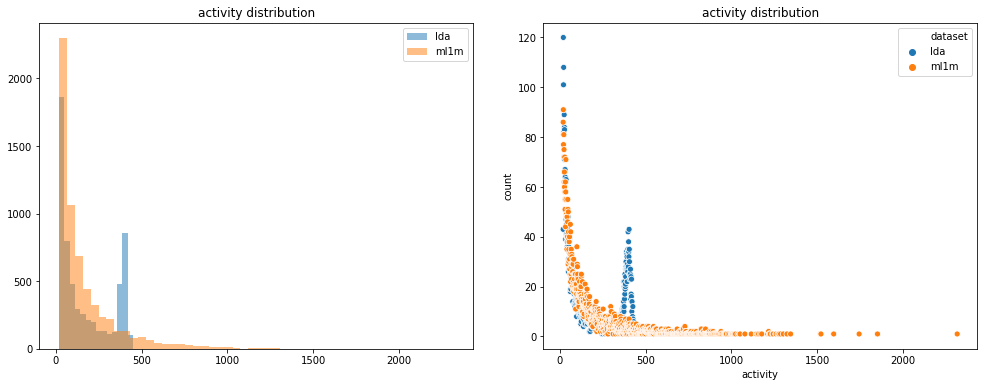

dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3627  1033143  0.047160
item popularity stats
              ml1m          lda
count  3706.000000  3627.000000
mean    269.889099   284.847808
std     384.047838   295.624660
min       1.000000     1.000000
25%      33.000000    58.000000
50%     123.500000   184.000000
75%     350.000000   423.000000
max    3428.000000  1928.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517   171.050166
std     192.747029   146.843906
min      20.000000    20.000000
25%      44.000000    42.000000
50%      96.000000   103.500000
75%     208.000000   339.000000
max    2314.000000   450.000000


In [20]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-ml_1m-all-1-2019-04-05-20-50-12.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_ml1m_all.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif_ml1m_all.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda unif on relative loss

[10, 35.94629160800744, 0.18752422370089722, 0.01, 22.408263885299483, 20.0, 2776.7999999999997] 582.4338970835188
simulated data is used
dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    1710   138384  0.013398
item popularity stats
              ml1m          lda
count  3706.000000  1710.000000
mean    269.889099    80.926316
std     384.047838   137.550503
min       1.000000     1.000000
25%      33.000000     4.000000
50%     123.500000    20.000000
75%     350.000000    94.750000
max    3428.000000  1334.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517    22.911258
std     192.747029     1.357605
min      20.000000    14.000000
25%      44.000000    22.000000
50%      96.000000    23.000000
75%     208.000000    23.000000
max    2314.000000    33.000000


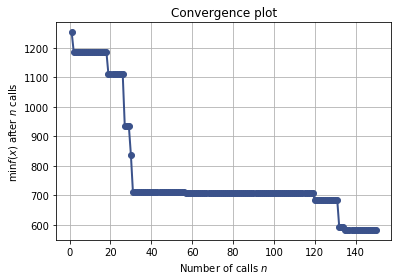

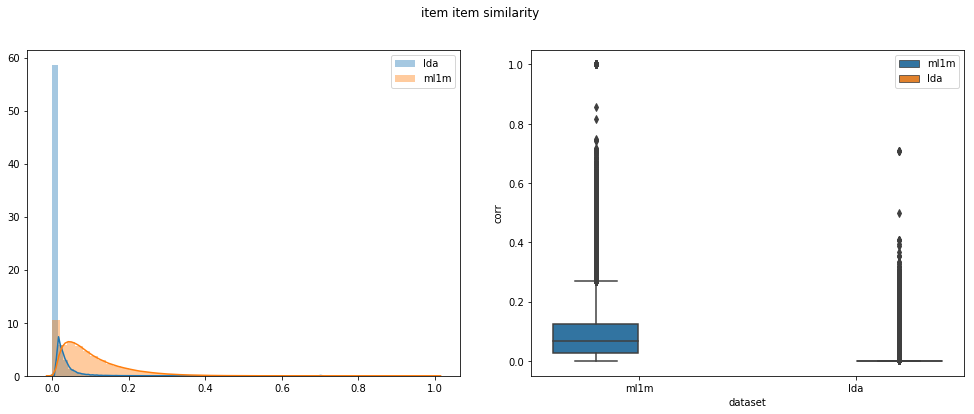

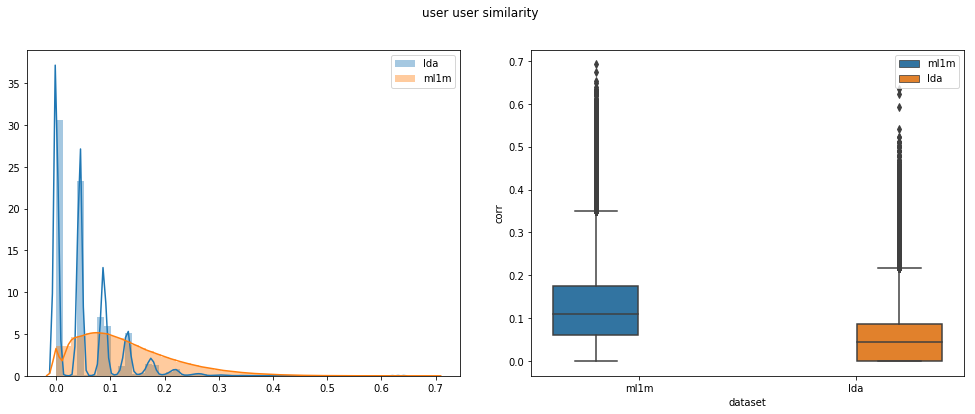

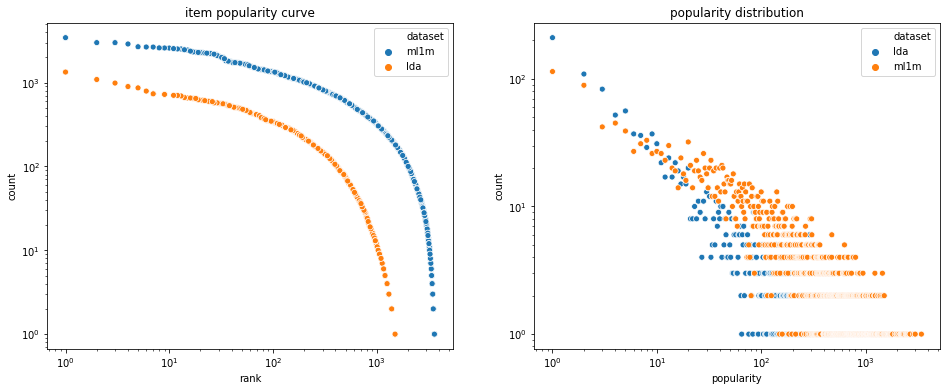

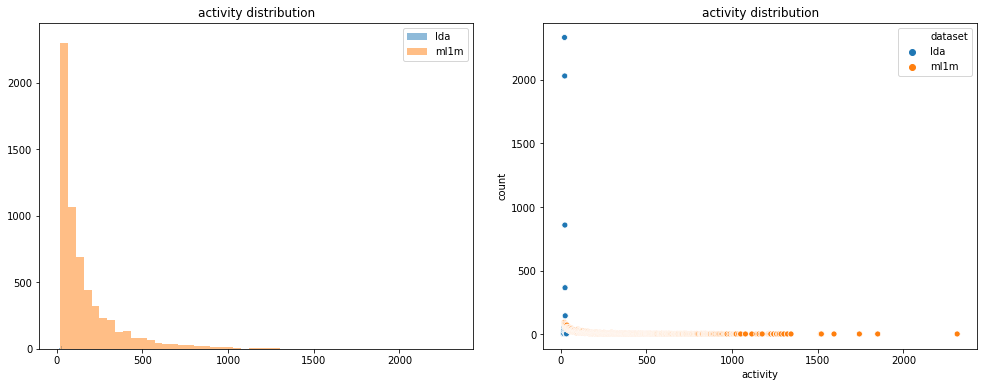

In [12]:
res_gp = skopt.load('build/skopt_lda_unif-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif-ml_1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_unif_pareto), args=[6040, 3706, *res_gp.x, 'lda_unif-ml_1m.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda pop on item item

[5, 200.0, 10.0, 0.01, 24.0, 20.0, 50.0] 0.7292462426380842
simulated data is used


/home/mtian/IdeaProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040     680   150206  0.036571
item popularity stats
              ml1m          lda
count  3706.000000   680.000000
mean    269.889099   220.891176
std     384.047838   389.374843
min       1.000000     1.000000
25%      33.000000     5.000000
50%     123.500000    38.000000
75%     350.000000   252.000000
max    3428.000000  2356.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517    24.868543
std     192.747029     1.340370
min      20.000000    24.000000
25%      44.000000    24.000000
50%      96.000000    24.000000
75%     208.000000    25.000000
max    2314.000000    37.000000


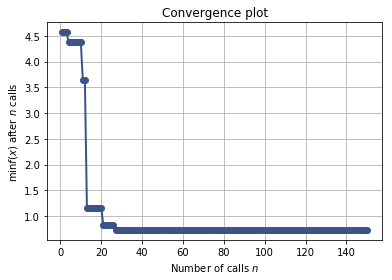

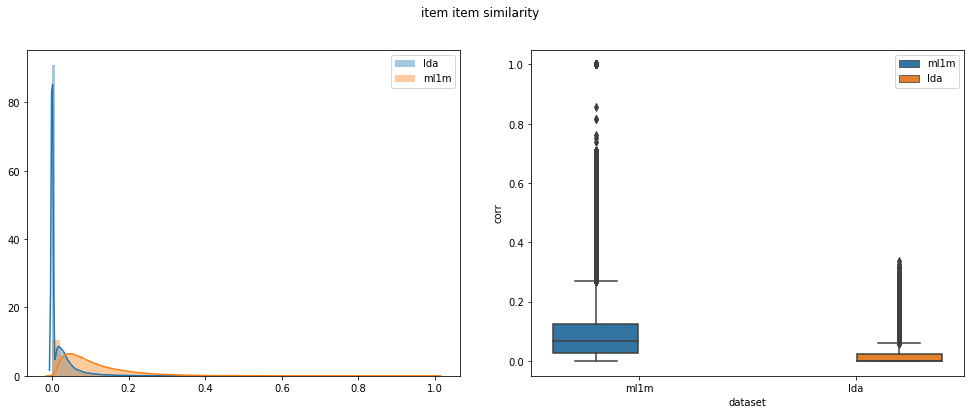

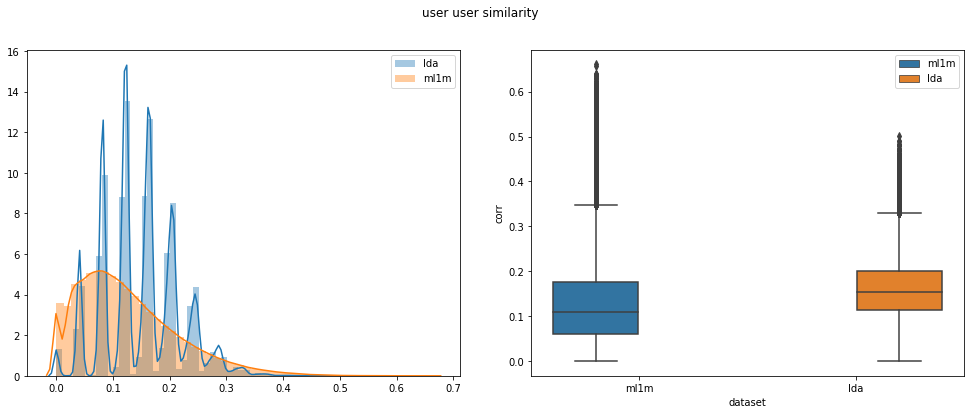

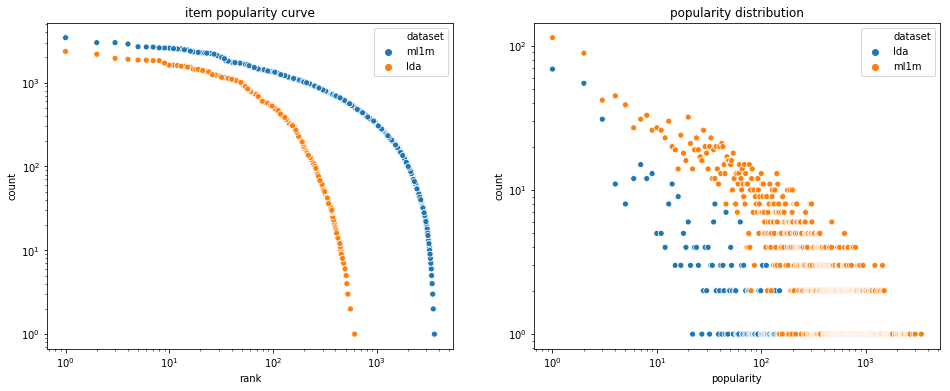

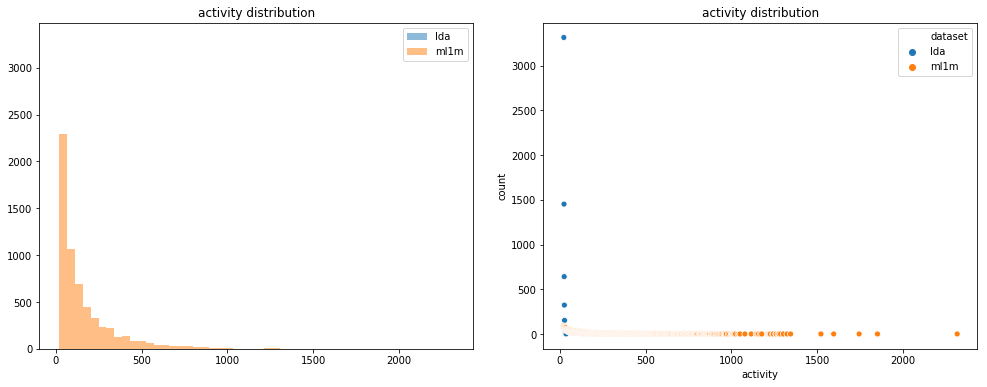

In [20]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-ml_1m-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop_csr-ml_1m-icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda pop on user user

[10, 1116.8692263392957, 0.6315343987712704, 0.08998742533310038, 18.0, 0.1, 2367.59571897033] 0.03465566032591604
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


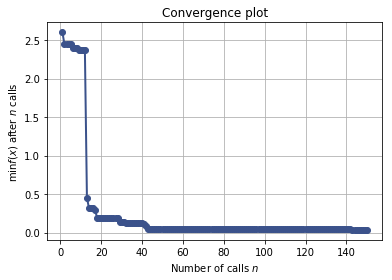

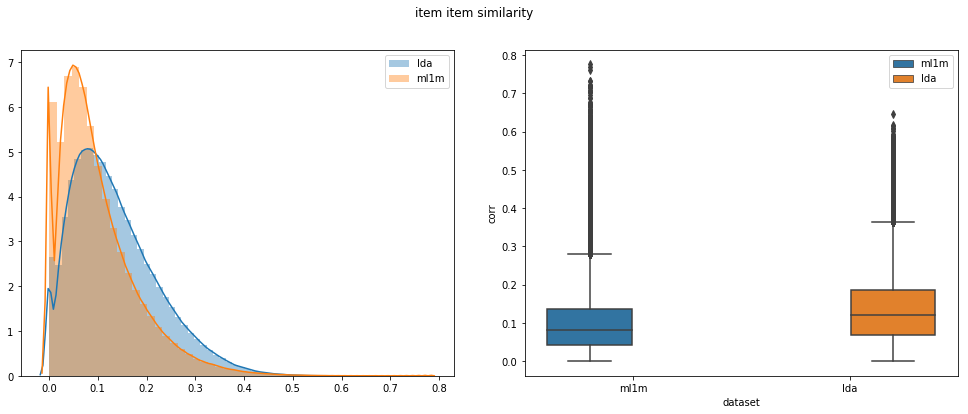

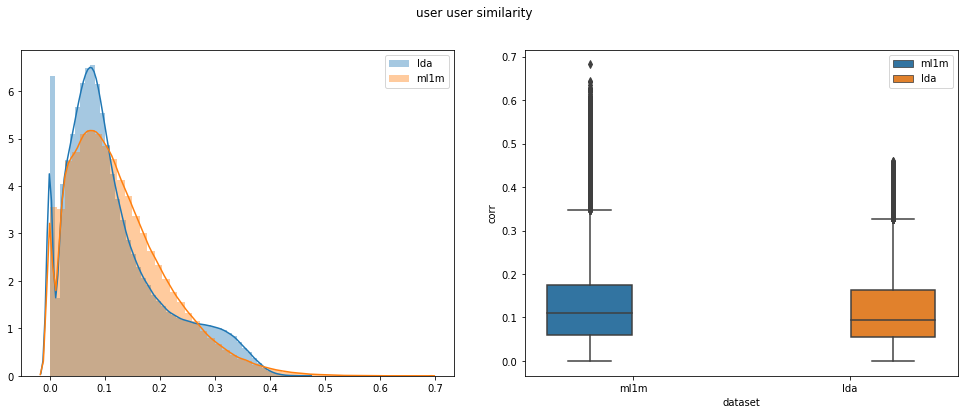

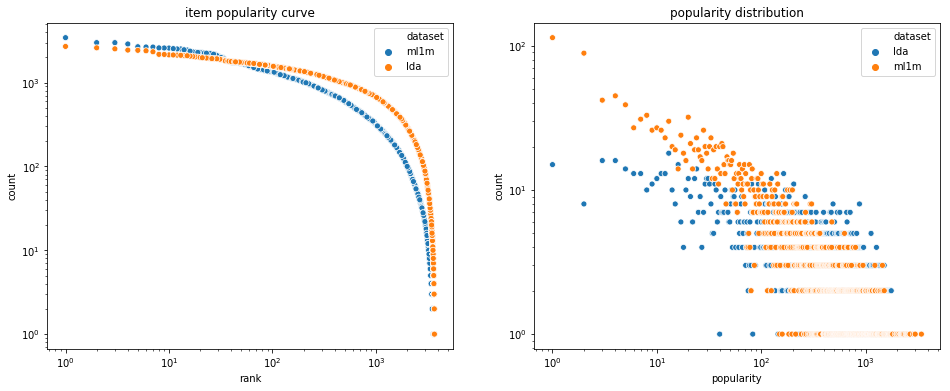

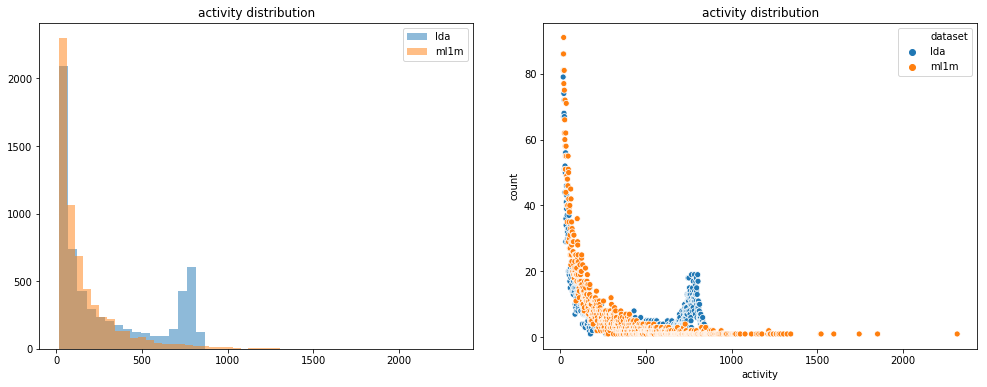

dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3691  1746182  0.078326
item popularity stats
              ml1m          lda
count  3706.000000  3691.000000
mean    269.889099   473.091845
std     384.047838   440.914545
min       1.000000     1.000000
25%      33.000000   123.000000
50%     123.500000   343.000000
75%     350.000000   716.000000
max    3428.000000  2695.000000
user profile stats
              ml1m         lda
count  6040.000000  6040.00000
mean    165.597517   289.10298
std     192.747029   287.47805
min      20.000000    18.00000
25%      44.000000    48.00000
50%      96.000000   145.00000
75%     208.000000   534.25000
max    2314.000000   869.00000


In [22]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-ucorr-1-2019-04-07-21-16-07.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_ml1m_ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop_ml1m_ucorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda pop on item pop

[96, 165.2844269290863, 0.8939951040411318, 0.01, 18.0, 0.1, 2100.426685168515] 0.1862011222005946
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


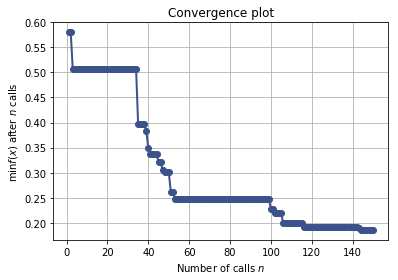

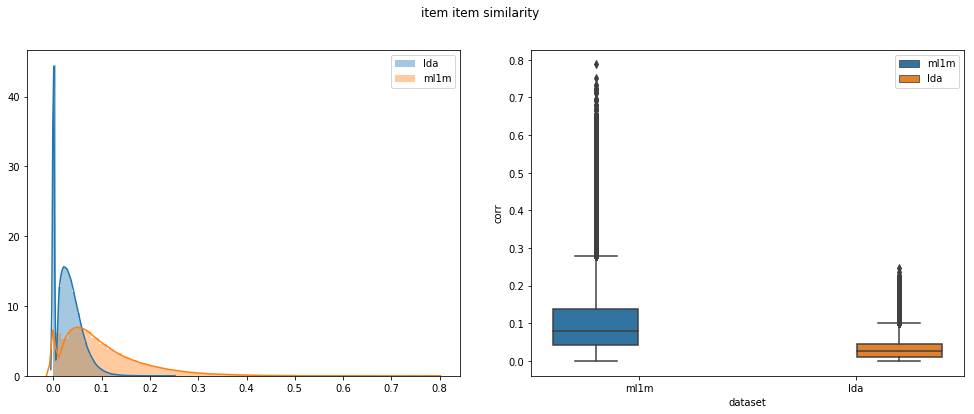

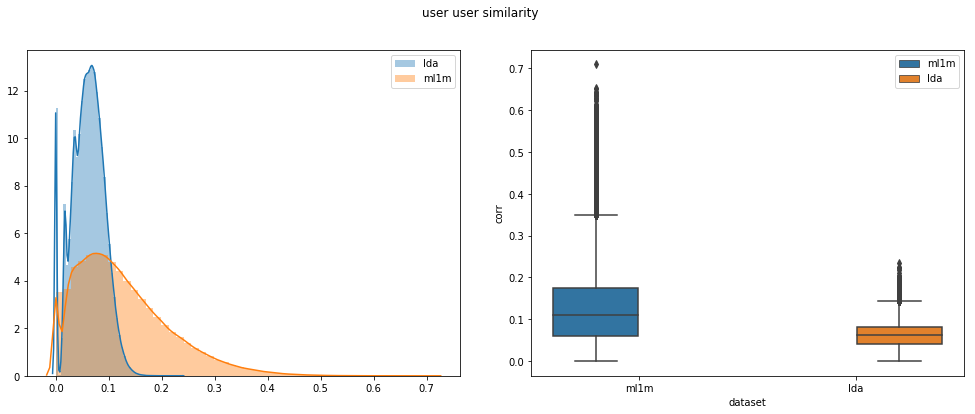

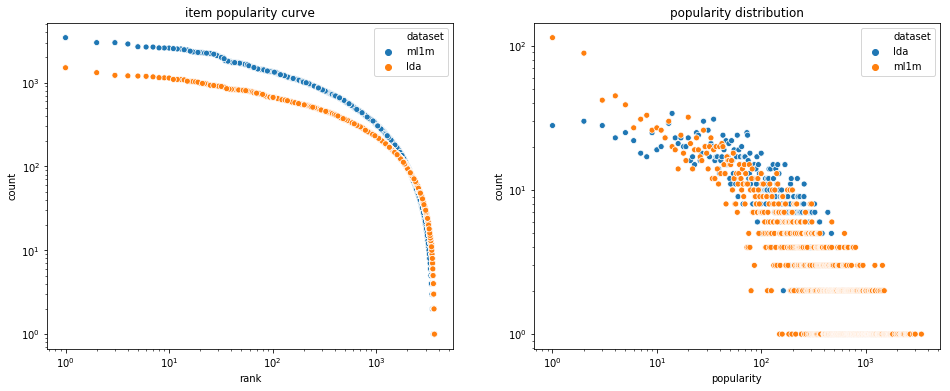

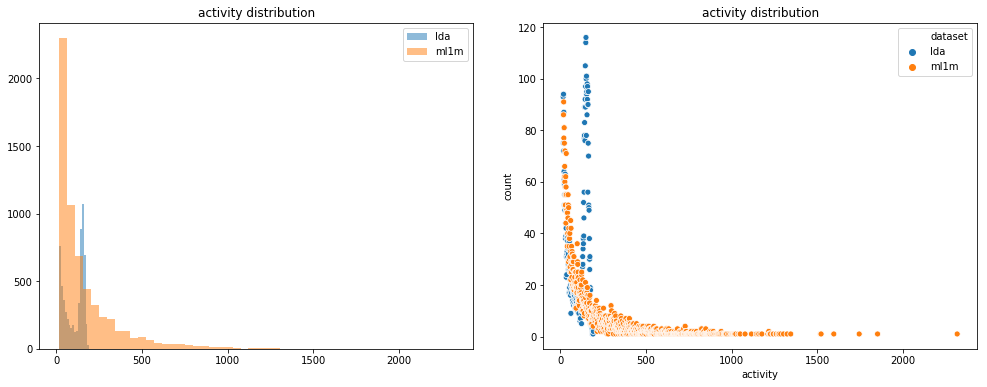

dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3676   644764  0.029039
item popularity stats
              ml1m          lda
count  3706.000000  3676.000000
mean    269.889099   175.398259
std     384.047838   187.343326
min       1.000000     1.000000
25%      33.000000    43.750000
50%     123.500000   112.000000
75%     350.000000   242.000000
max    3428.000000  1501.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517   106.749007
std     192.747029    54.717483
min      20.000000    18.000000
25%      44.000000    48.000000
50%      96.000000   135.000000
75%     208.000000   154.000000
max    2314.000000   194.000000


In [23]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-item-pop-1-2019-04-05-23-35-32.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_ml1m_ip.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop_ml1m_ip.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda pop on user activity

[100, 499.99999999999994, 0.01, 0.01, 20.715334349048984, 0.5986082611808001, 2545.4] 0.18141745198767198
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


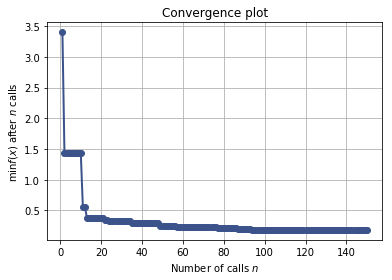

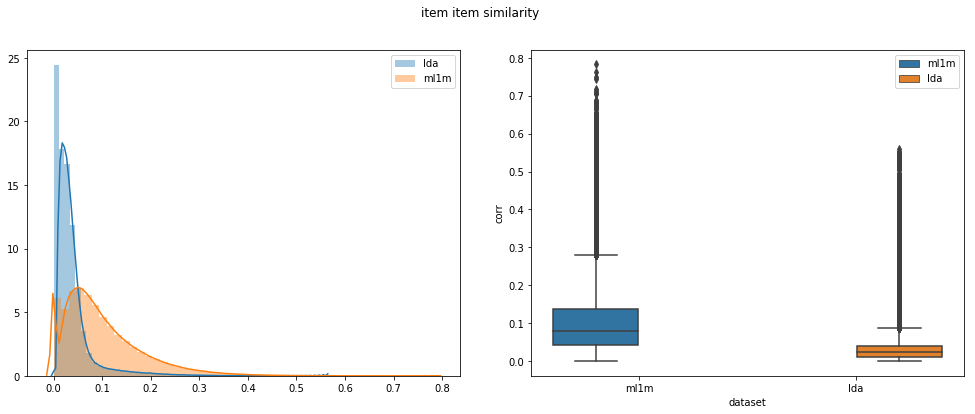

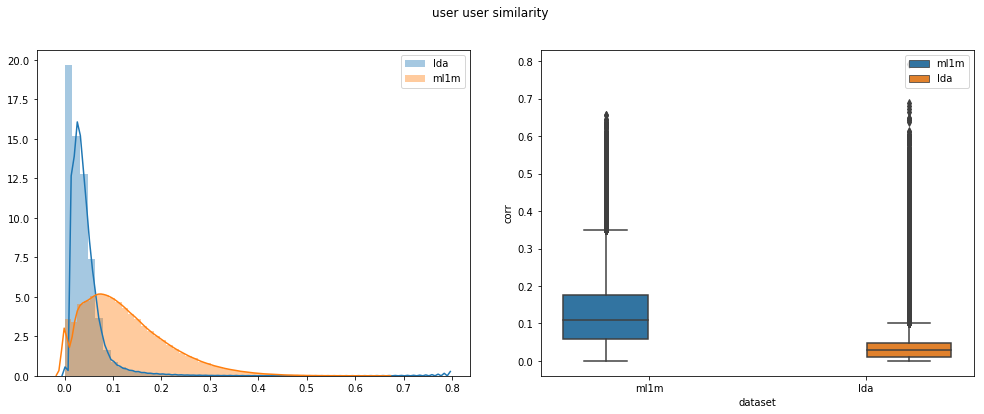

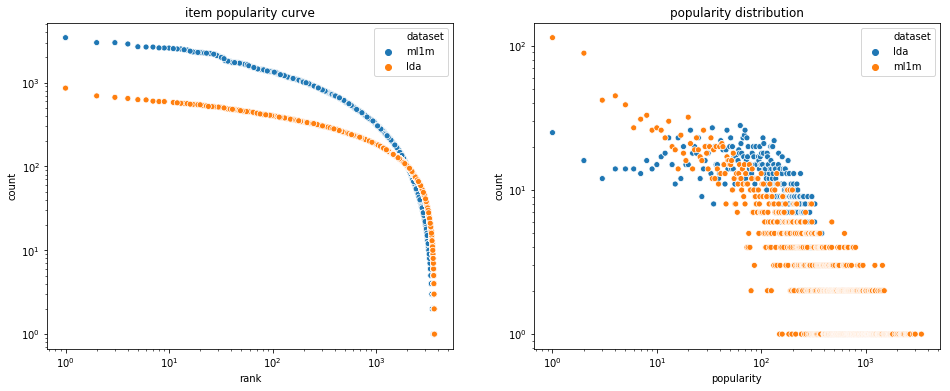

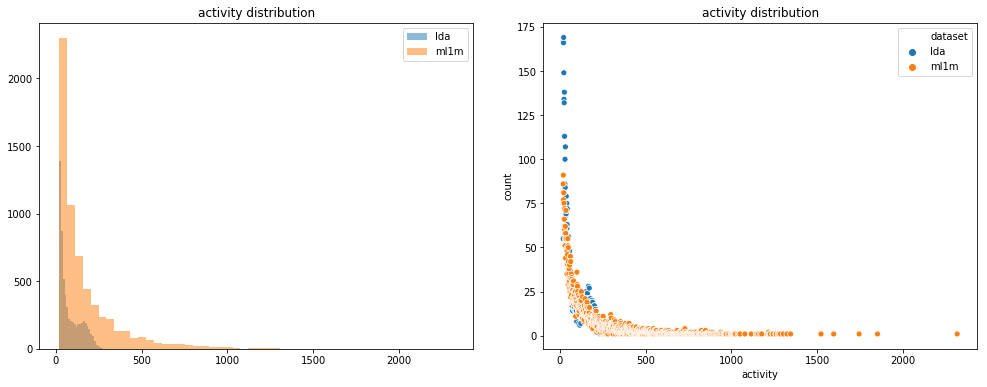

dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3685   505798  0.022725
item popularity stats
              ml1m          lda
count  3706.000000  3685.000000
mean    269.889099   137.258616
std     384.047838   108.388067
min       1.000000     1.000000
25%      33.000000    55.000000
50%     123.500000   113.000000
75%     350.000000   194.000000
max    3428.000000   858.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517    83.741391
std     192.747029    61.929282
min      20.000000    20.000000
25%      44.000000    32.000000
50%      96.000000    58.000000
75%     208.000000   131.000000
max    2314.000000   276.000000


In [24]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-user-act-1-2019-04-05-23-27-37.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_ml1m_ua.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop_ml1m_ua.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda pop on all

[66, 499.99999999999994, 0.9853279511231506, 0.01, 21.929748558153694, 0.4054312134092747, 2082.600000000001] 0.6859877016505851
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


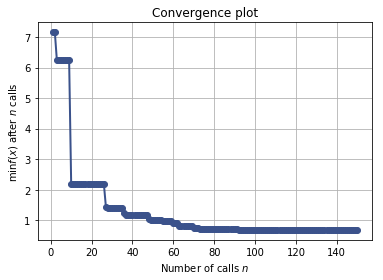

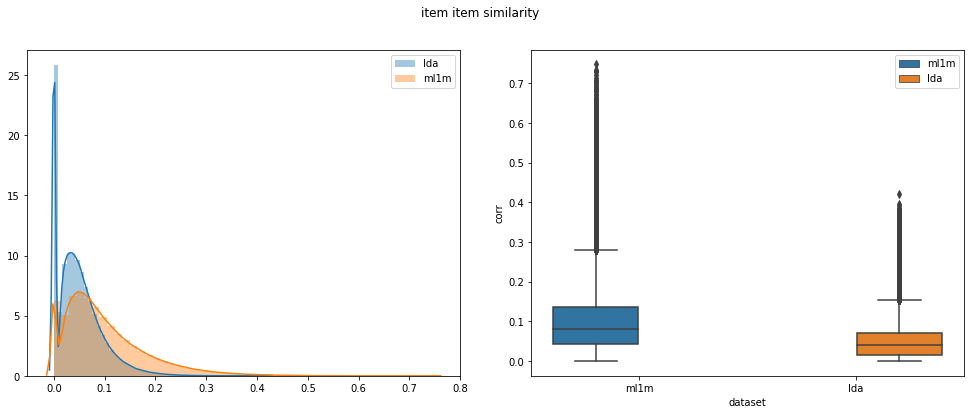

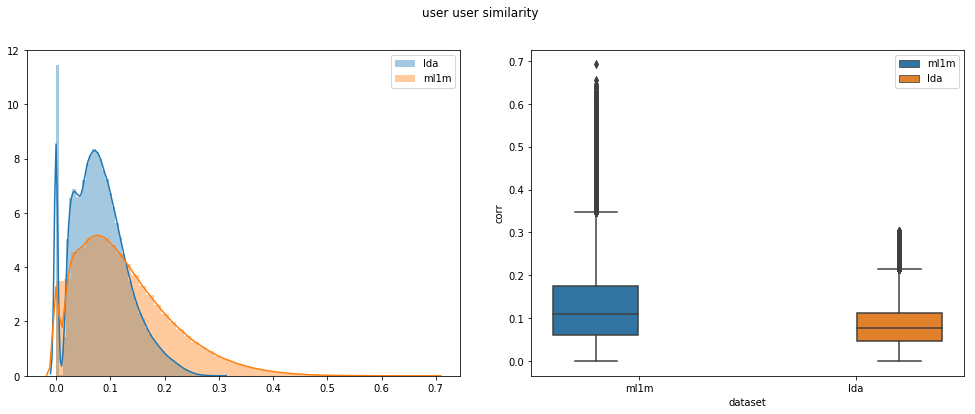

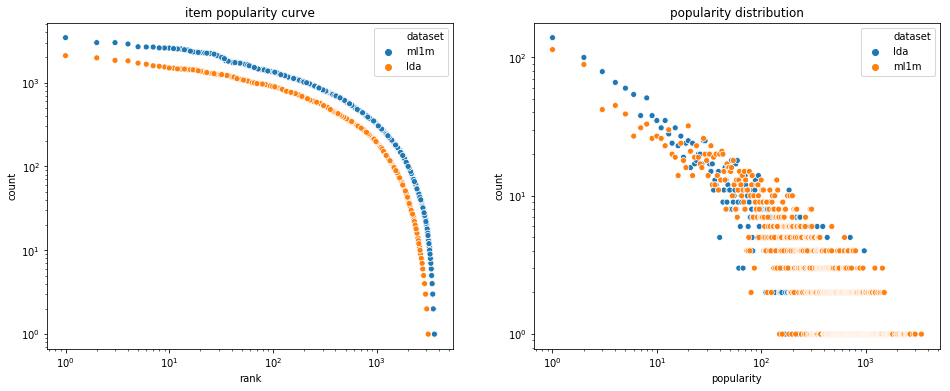

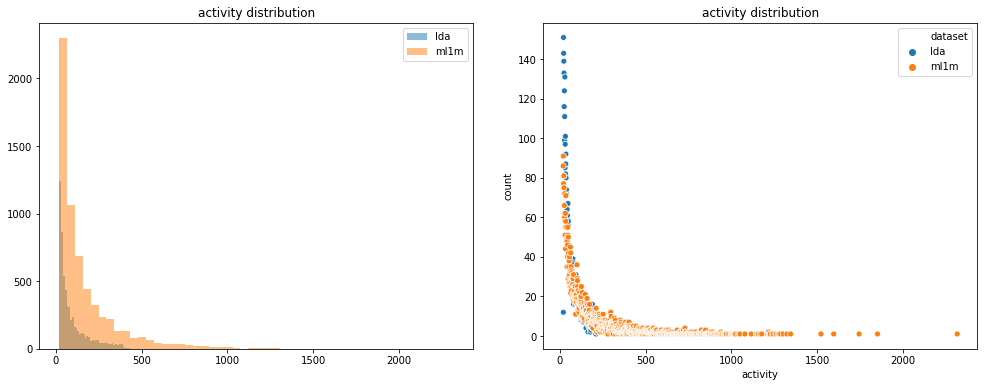

dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3271   598320  0.030284
item popularity stats
              ml1m          lda
count  3706.000000  3271.000000
mean    269.889099   182.916539
std     384.047838   259.366043
min       1.000000     1.000000
25%      33.000000    16.000000
50%     123.500000    76.000000
75%     350.000000   249.000000
max    3428.000000  2090.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517    99.059603
std     192.747029    89.730941
min      20.000000    21.000000
25%      44.000000    34.000000
50%      96.000000    62.000000
75%     208.000000   132.000000
max    2314.000000   431.000000


In [25]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-all-1-2019-04-05-21-30-09.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_ml1m_all.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop_ml1m_all.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### lda pop on relative loss

[10, 200.0, 0.4307485723277063, 0.014320726100738873, 18.593835540483596, 0.5922391003756653, 661.9552784542433] 91.88571636828264
simulated data is used
dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    2155   409056  0.031427
item popularity stats
              ml1m          lda
count  3706.000000  2155.000000
mean    269.889099   189.817169
std     384.047838   354.231919
min       1.000000     1.000000
25%      33.000000     6.000000
50%     123.500000    37.000000
75%     350.000000   193.000000
max    3428.000000  3616.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517    67.724503
std     192.747029    45.720382
min      20.000000    18.000000
25%      44.000000    28.000000
50%      96.000000    49.000000
75%     208.000000   111.000000
max    2314.000000   177.000000


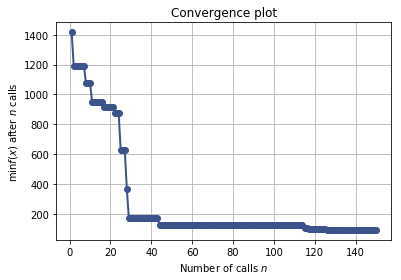

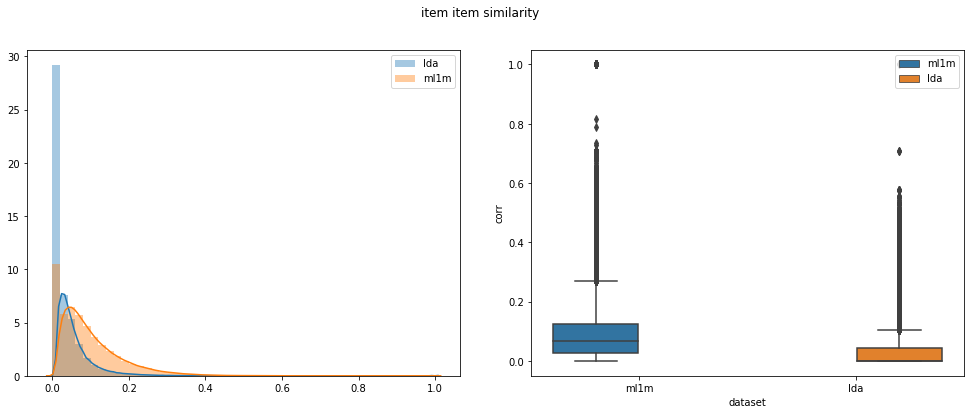

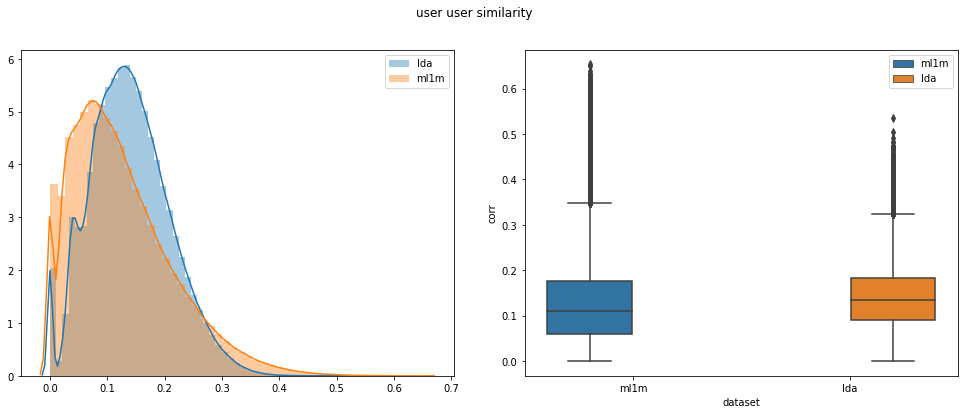

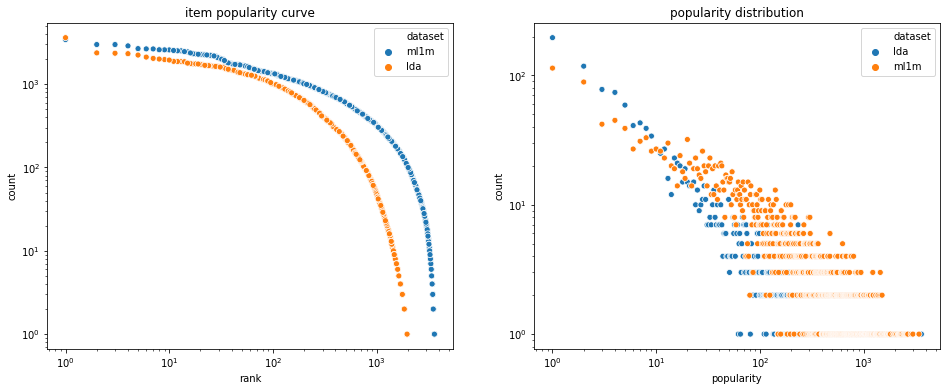

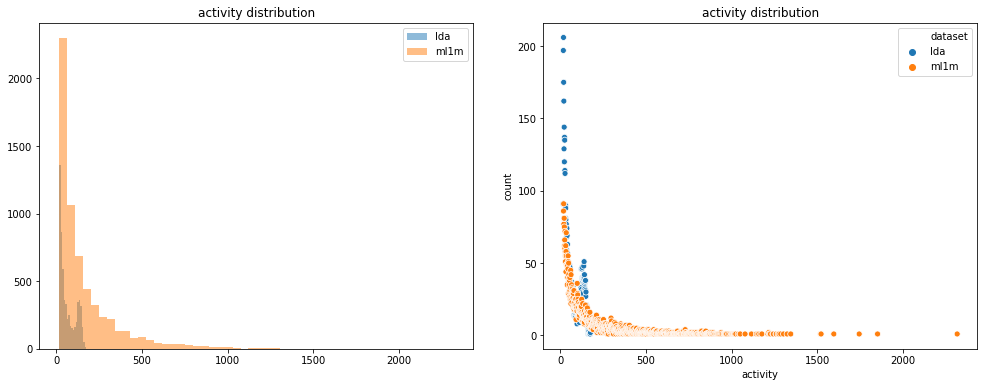

In [13]:
res_gp = skopt.load('build/skopt_lda_pop-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop-ml_1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('lda', lda_pop_pareto), args=[6040, 3706, *res_gp.x, 'lda_pop-ml_1m.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('lda', simulated_data))

### ibp unif on item item

[48.97821916050362, 97.63085338097945, 0.10709409880246677, 23.899662942407552, 2.3671095582129693, 103.97095737293189] 3.5905186881049795
simulated data is used


/home/mtian/IdeaProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040   22039   203349  0.001528
item popularity stats
              ml1m      ibp_unif
count  3706.000000  22039.000000
mean    269.889099      9.226780
std     384.047838     16.556608
min       1.000000      1.000000
25%      33.000000      1.000000
50%     123.500000      3.000000
75%     350.000000      9.000000
max    3428.000000    212.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517    33.667053
std     192.747029     8.863946
min      20.000000    23.000000
25%      44.000000    26.000000
50%      96.000000    31.000000
75%     208.000000    40.000000
max    2314.000000    68.000000


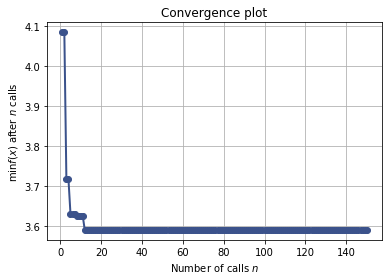

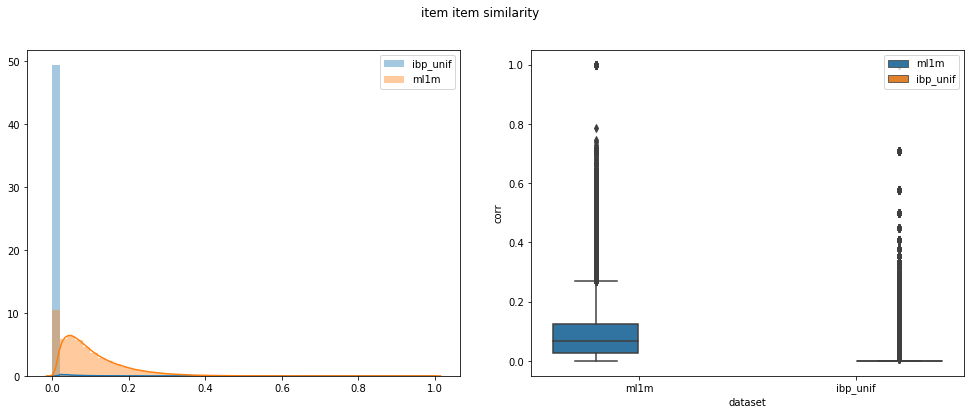

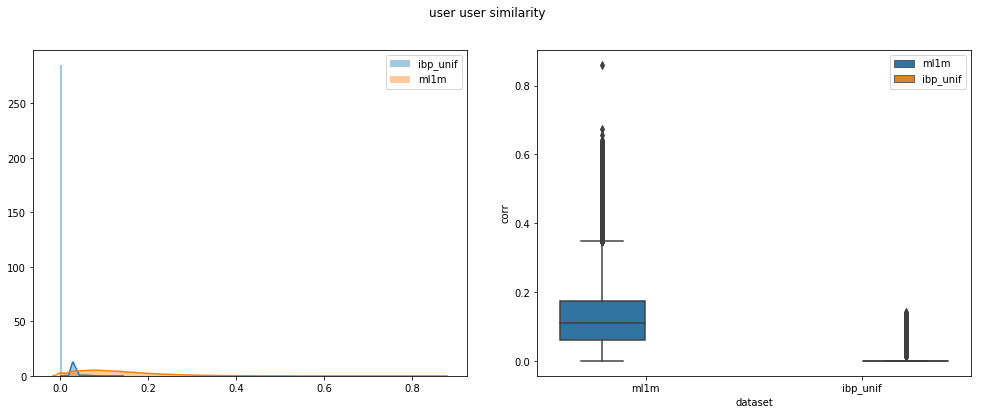

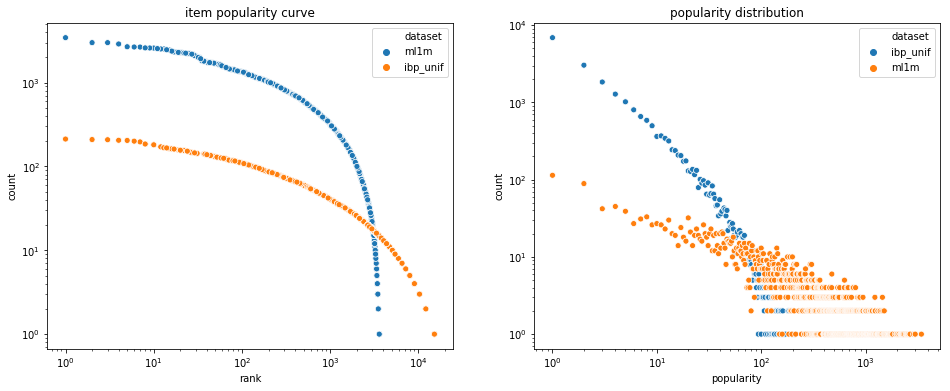

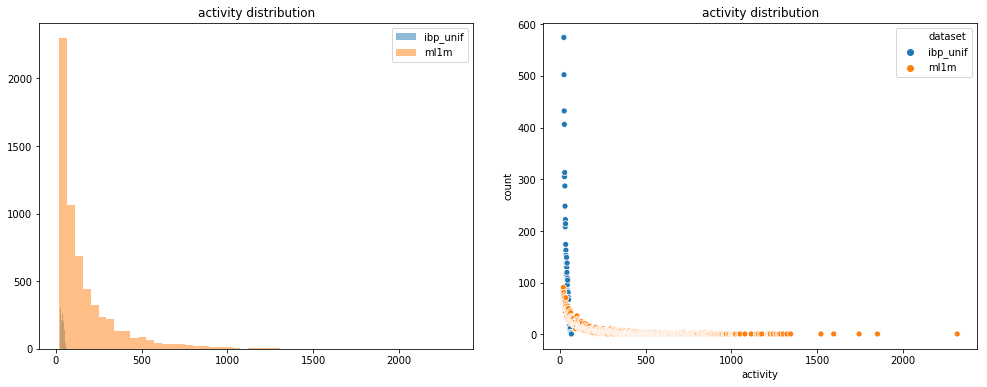

In [13]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-ml_1m-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif_csr-ml_1m-icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', simulated_data))

### ibp unif on user user

[64.89608100801439, 5.927341440326085, 0.09849121204333429, 21.696418198666052, 4.016454073469404, 74.59440540951711] 1.4692157136248363
simulated data is used


/home/mtian/IdeaProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040    3203   167832  0.008675
item popularity stats
              ml1m     ibp_unif
count  3706.000000  3203.000000
mean    269.889099    52.398377
std     384.047838   124.287488
min       1.000000     1.000000
25%      33.000000     2.000000
50%     123.500000     7.000000
75%     350.000000    38.500000
max    3428.000000  1500.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517    27.786755
std     192.747029     7.502159
min      20.000000    21.000000
25%      44.000000    23.000000
50%      96.000000    25.000000
75%     208.000000    30.000000
max    2314.000000    69.000000


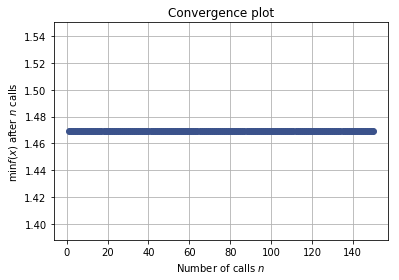

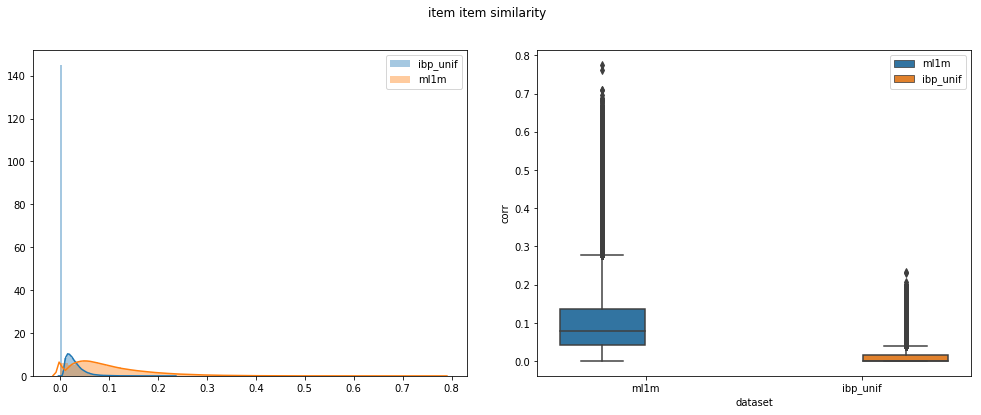

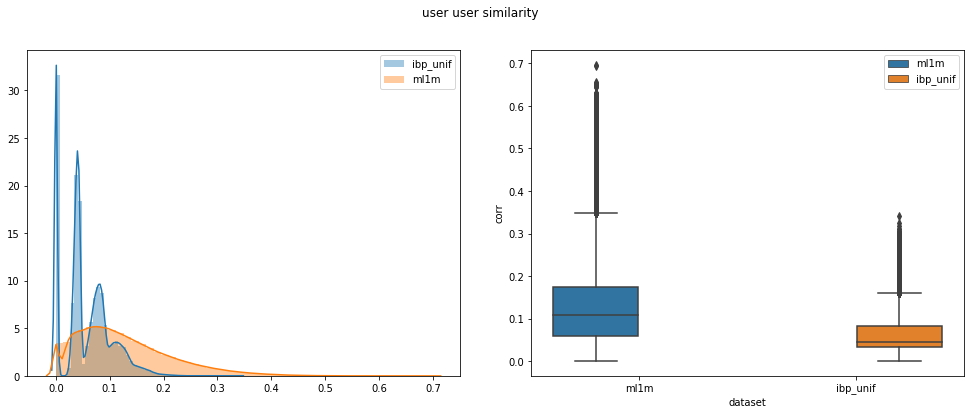

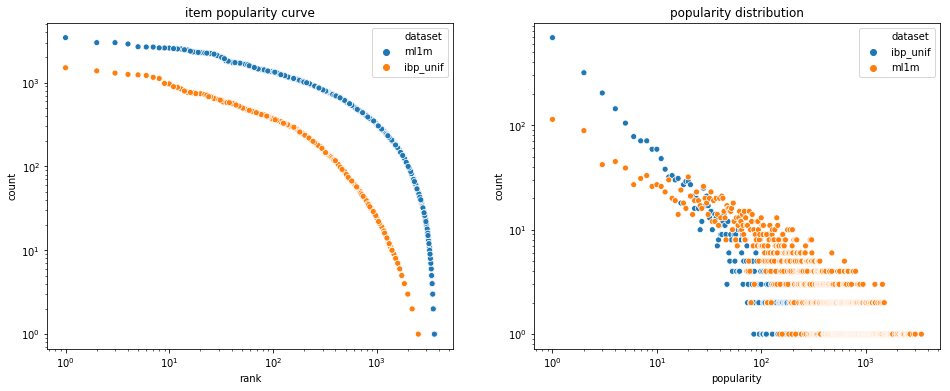

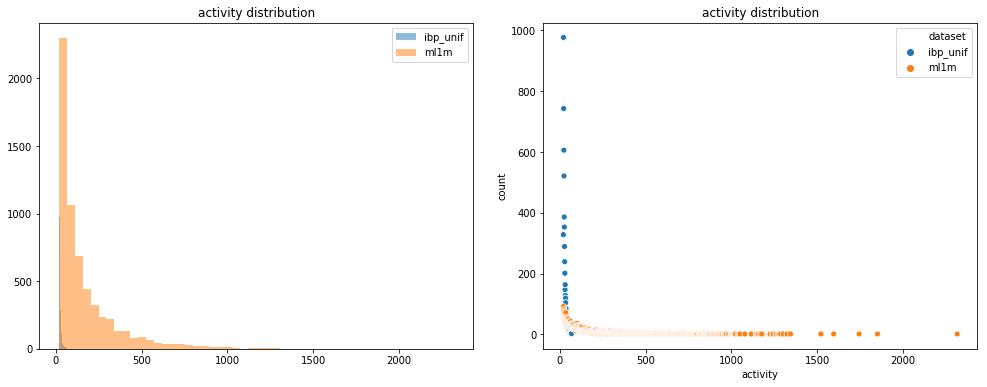

In [17]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-ml_1m-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif_csr-ml_1m-ucorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', simulated_data), mrated=5)

### ibp unif on item pop

[20.000000000000004, 5.7740419762167345, 0.0, 24.0, 1.1418219552440518, 1851.2] 0.1908084772090269
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


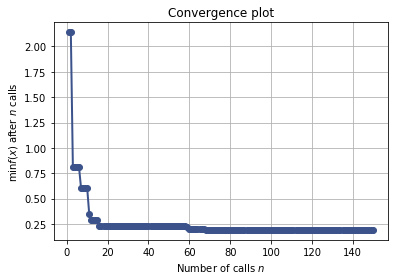

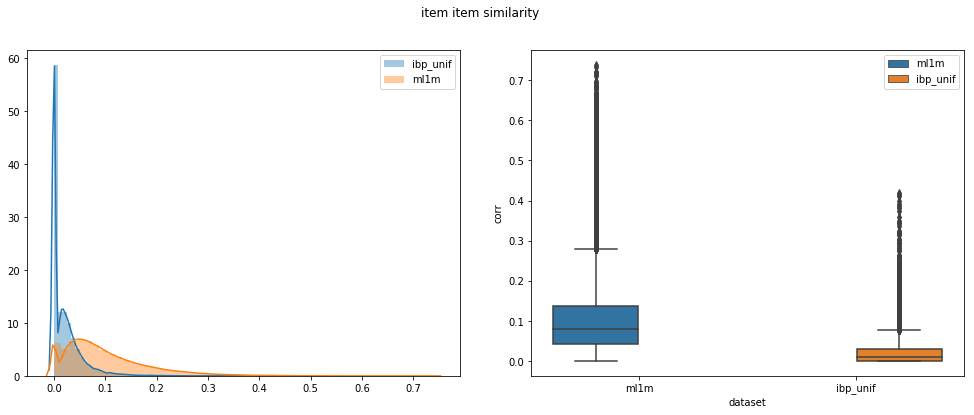

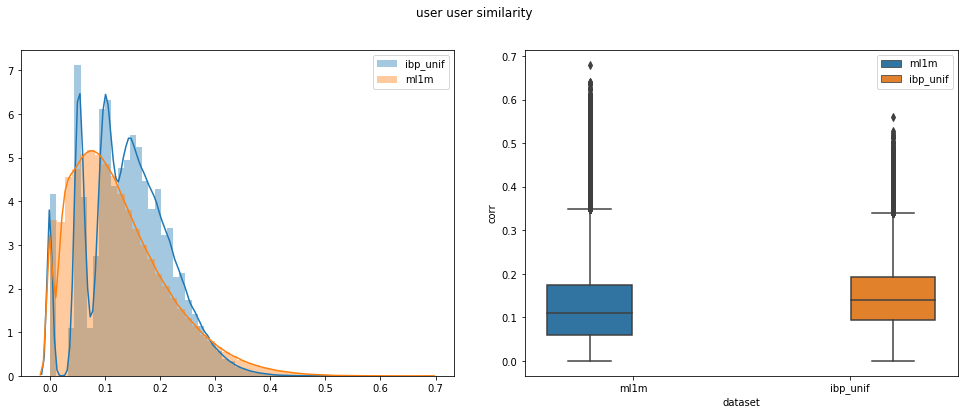

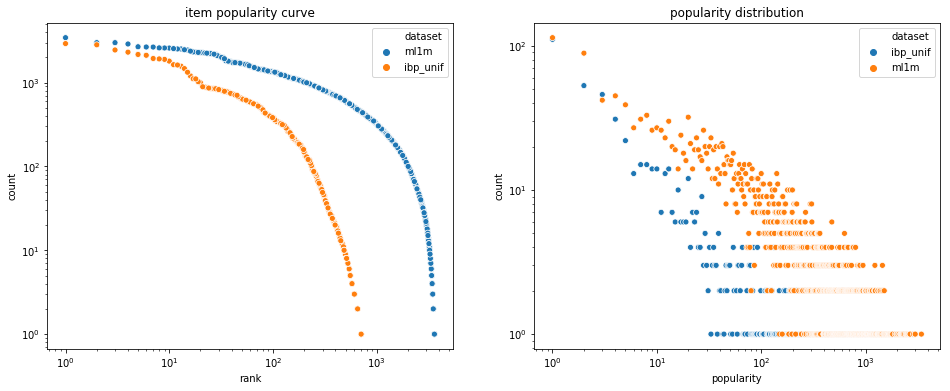

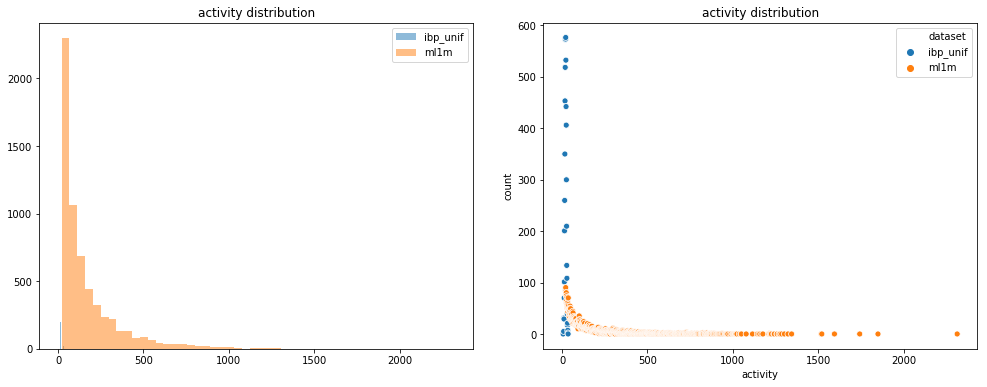

dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040     817   122788  0.024883
item popularity stats
              ml1m     ibp_unif
count  3706.000000   817.000000
mean    269.889099   150.291310
std     384.047838   329.652934
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    19.000000
75%     350.000000   134.000000
max    3428.000000  2914.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517    20.329139
std     192.747029     4.078581
min      20.000000     6.000000
25%      44.000000    18.000000
50%      96.000000    20.000000
75%     208.000000    23.000000
max    2314.000000    35.000000


In [34]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-item-pop-1-2019-04-06-00-25-20.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_ml1m_ip.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif_ml1m_ip.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', simulated_data))

### ibp unif on user activity

[499.99999999999994, 0.01, 0.99, 20.378226681009178, 0.5749270083015862, 1851.2] 0.18027758946202188
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


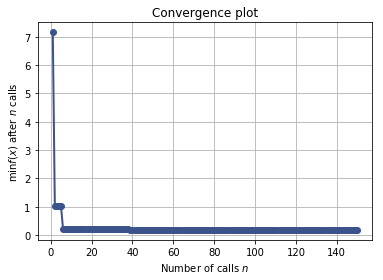

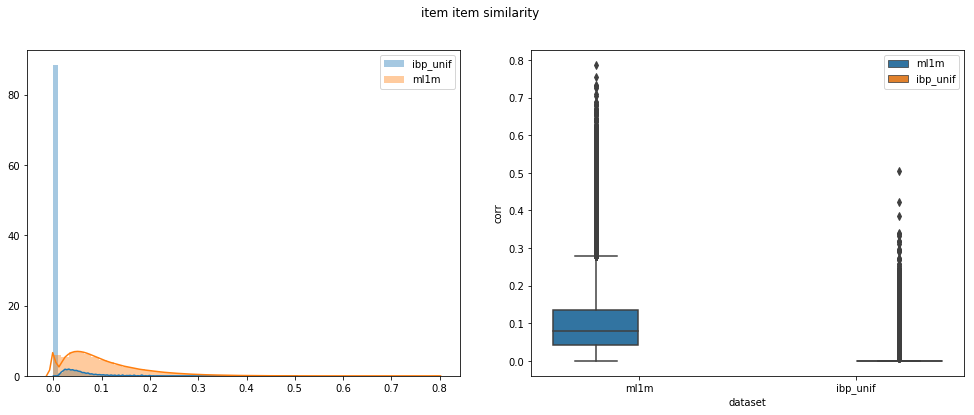

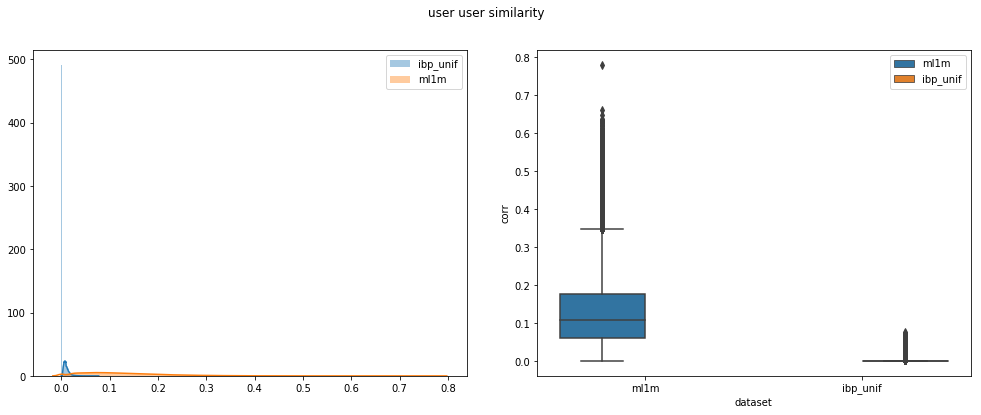

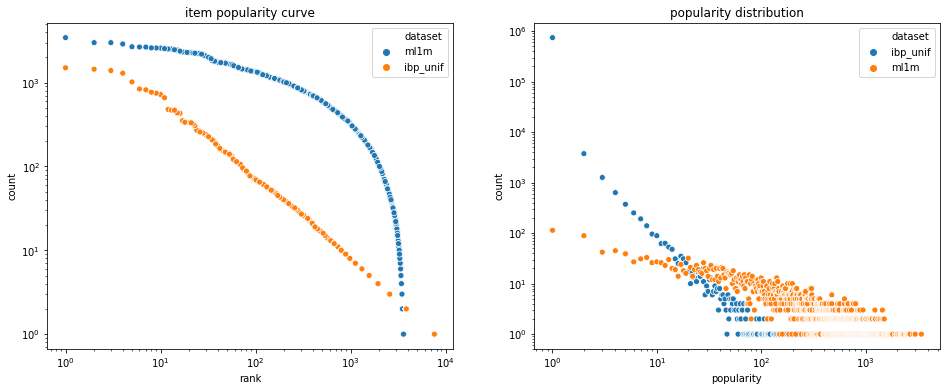

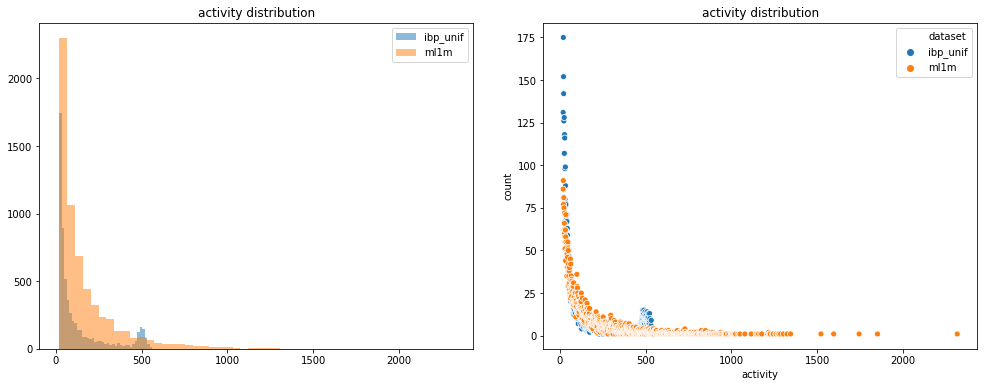

dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040  751362   807975  0.000178
item popularity stats
              ml1m       ibp_unif
count  3706.000000  751362.000000
mean    269.889099       1.075347
std     384.047838       4.666234
min       1.000000       1.000000
25%      33.000000       1.000000
50%     123.500000       1.000000
75%     350.000000       1.000000
max    3428.000000    1500.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517   133.770695
std     192.747029   152.709386
min      20.000000    20.000000
25%      44.000000    32.000000
50%      96.000000    59.000000
75%     208.000000   166.000000
max    2314.000000   562.000000


In [35]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-user-act-1-2019-04-05-17-57-47.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_ml1m_ua.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif_ml1m_ua.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', simulated_data))

### ibp unif on all

[437.1946475415826, 0.4634912798460673, 0.0, 21.883818537767297, 0.7252611365607432, 1851.2] 1.1929711726762644
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


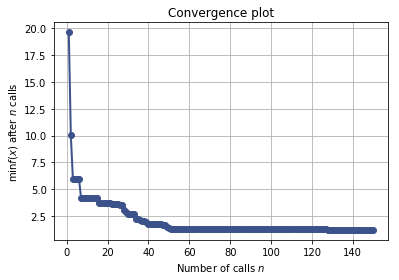

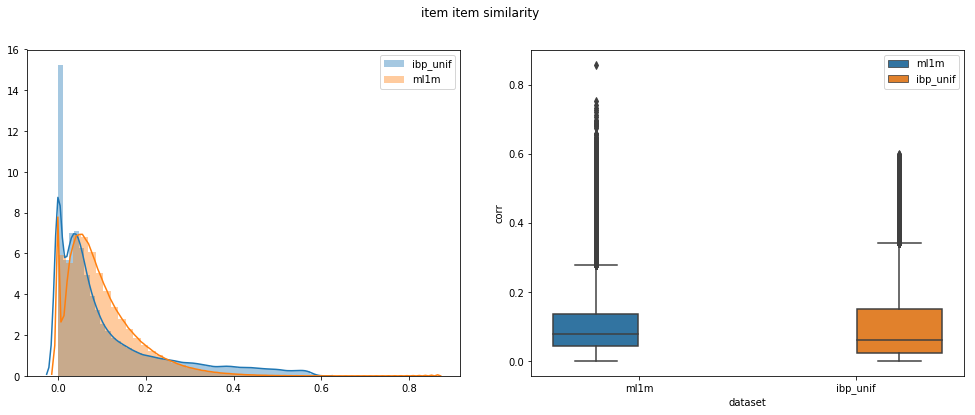

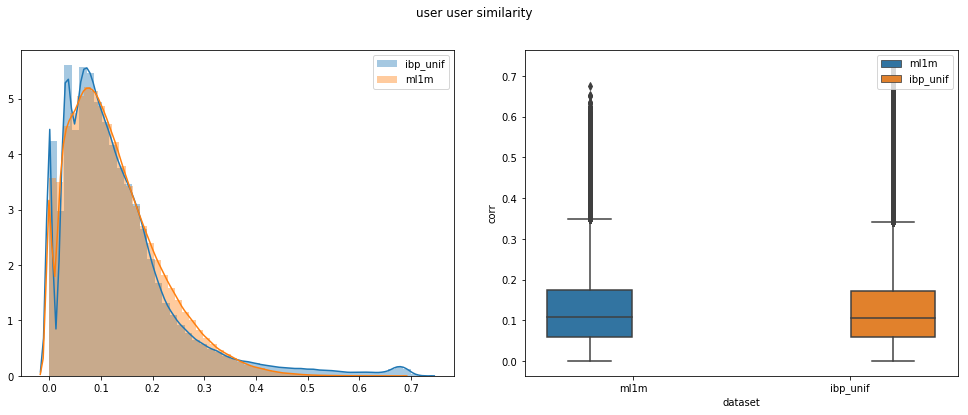

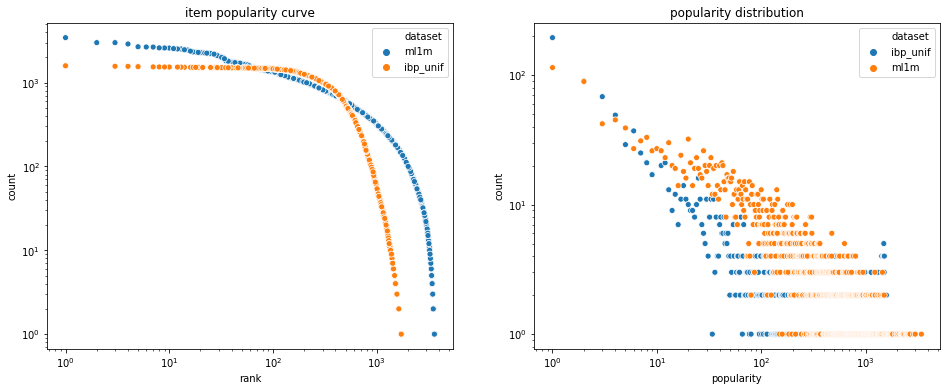

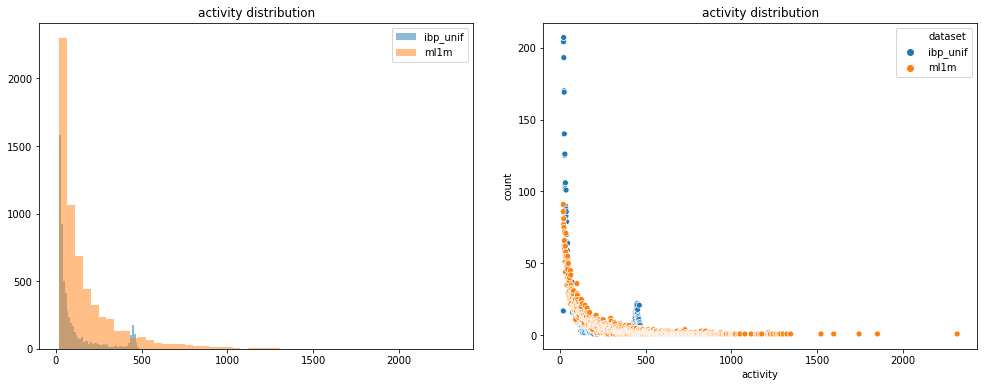

dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040    1914   682551  0.059041
item popularity stats
              ml1m     ibp_unif
count  3706.000000  1914.000000
mean    269.889099   356.609718
std     384.047838   489.804265
min       1.000000     1.000000
25%      33.000000     7.000000
50%     123.500000    68.000000
75%     350.000000   597.750000
max    3428.000000  1584.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517   113.005132
std     192.747029   129.105516
min      20.000000    21.000000
25%      44.000000    31.000000
50%      96.000000    53.000000
75%     208.000000   128.000000
max    2314.000000   486.000000


In [36]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-all-1-2019-04-05-22-06-08.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_ml1m_all.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif_ml1m_all.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', simulated_data))

### ibp unif on relative loss

[26.2714847895748, 3.0569543769572505, 0.011406195228950112, 21.31042688866048, 5.09553528059475, 792.7308641200391] 279.89498166194505
file not found, simulating data on the fly


/home/mtian/IdeaProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040     663   151175  0.037751
item popularity stats
              ml1m     ibp_unif
count  3706.000000   663.000000
mean    269.889099   228.016591
std     384.047838   495.148595
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    27.000000
75%     350.000000   181.500000
max    3428.000000  3746.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517    25.028974
std     192.747029     3.994779
min      20.000000    15.000000
25%      44.000000    22.000000
50%      96.000000    24.000000
75%     208.000000    27.000000
max    2314.000000    47.000000


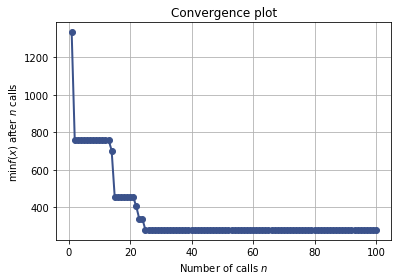

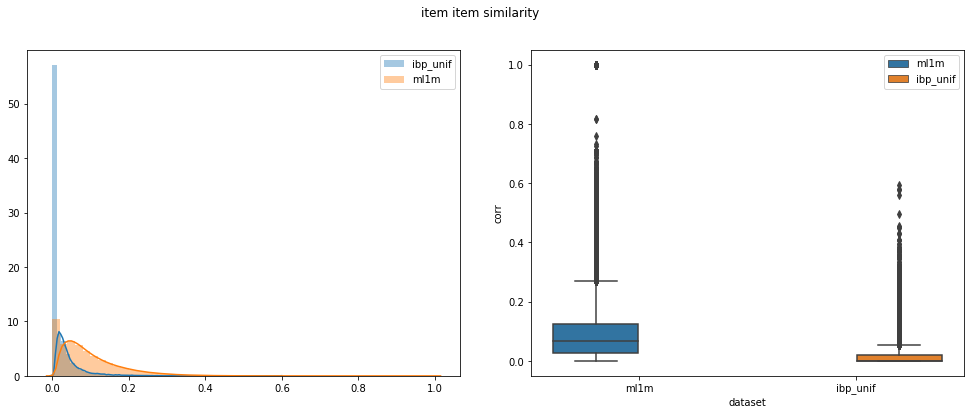

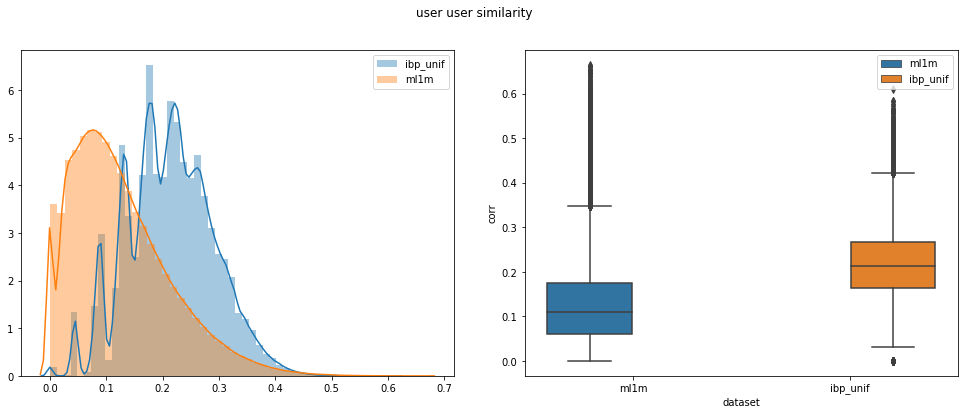

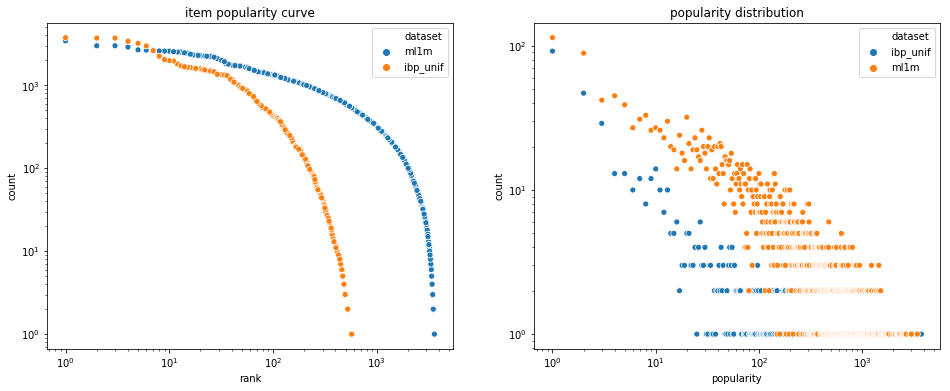

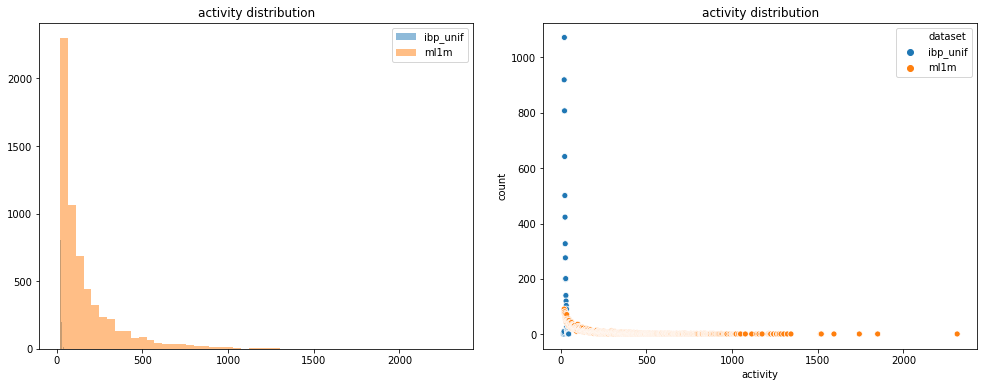

In [14]:
res_gp = skopt.load('build/skopt_ibp_unif-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif-ml1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', ibp_unif_pareto), args=[6040, *res_gp.x, 'ibp_unif-ml1m.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_unif', simulated_data))

### ibp pop on item item

[1788.4581762317487, 0.9322993977136008, 0.0, 21.531642997711177, 0.4647731544595933, 2110.7818253358723] 0.057097410127544275
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


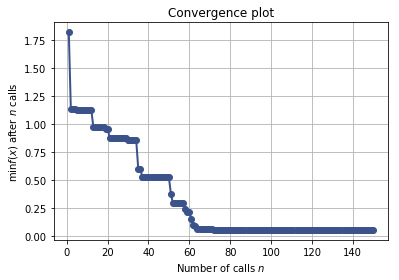

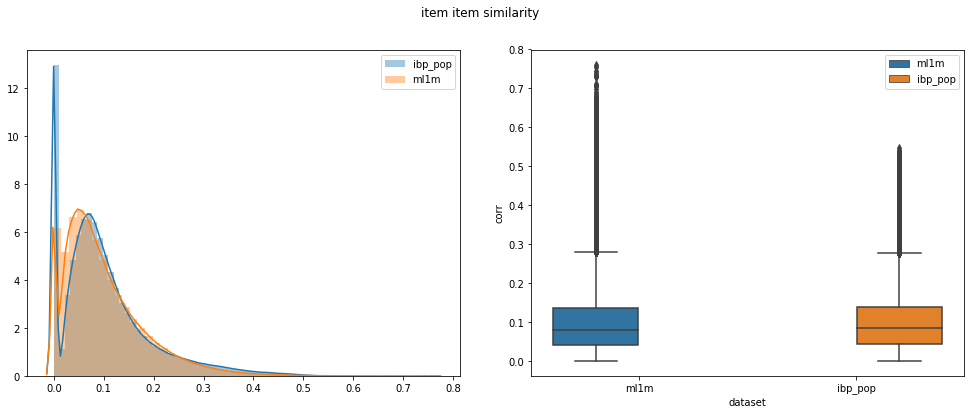

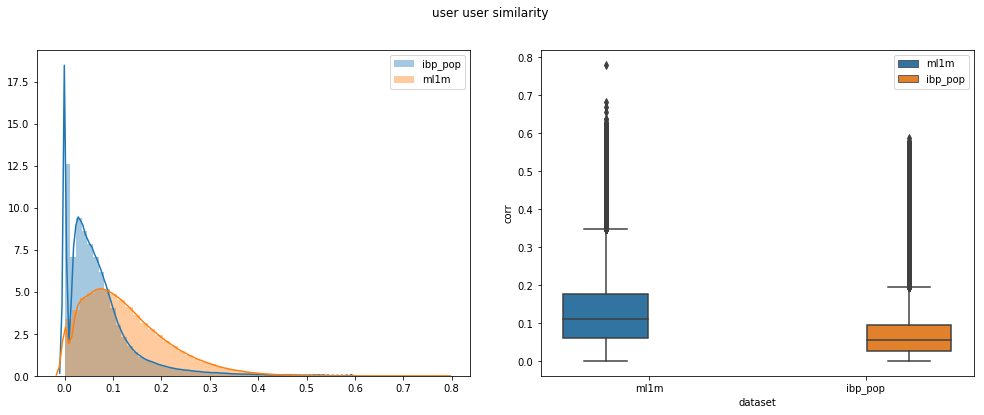

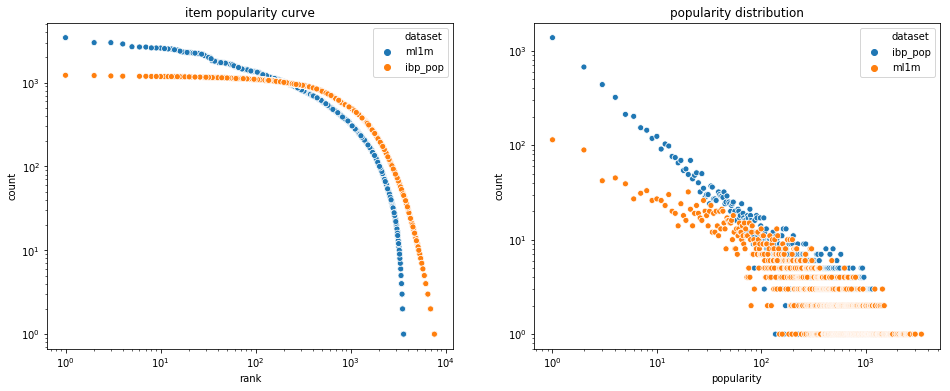

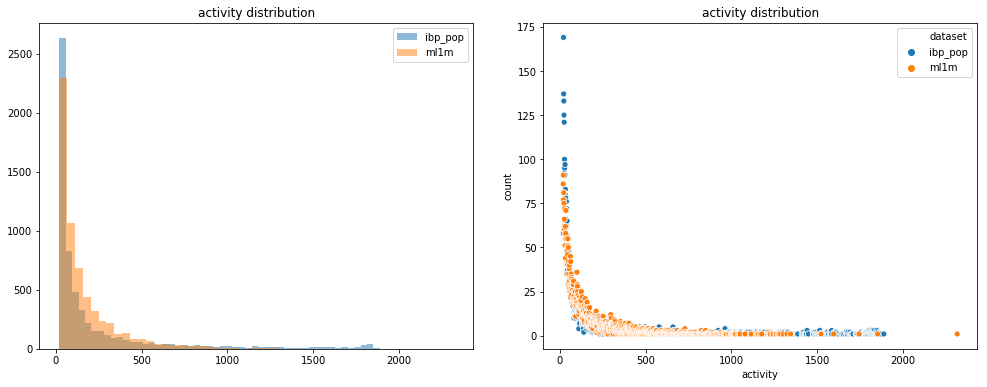

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040    8952  1346698  0.024907
item popularity stats
              ml1m      ibp_pop
count  3706.000000  8952.000000
mean    269.889099   150.435433
std     384.047838   262.150457
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    20.000000
75%     350.000000   162.000000
max    3428.000000  1221.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517   222.963245
std     192.747029   360.507149
min      20.000000    21.000000
25%      44.000000    35.000000
50%      96.000000    71.000000
75%     208.000000   219.000000
max    2314.000000  1887.000000


In [37]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-icorr-1-2019-04-05-18-33-14.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_ml1m_icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop_ml1m_icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', simulated_data))

### ibp pop on user user

[1795.1592736940415, 0.3715831210952207, 0.6668315406643194, 22.0, 0.19718555841015328, 2357.8672487846184] 0.02947663747191073
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


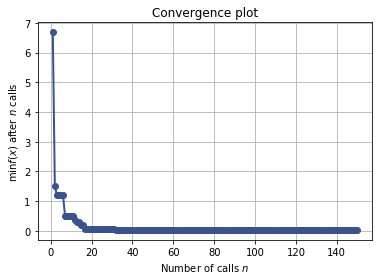

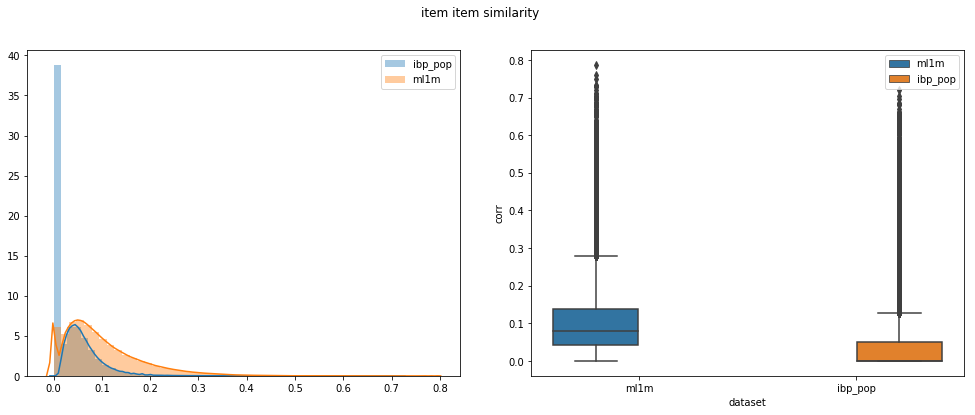

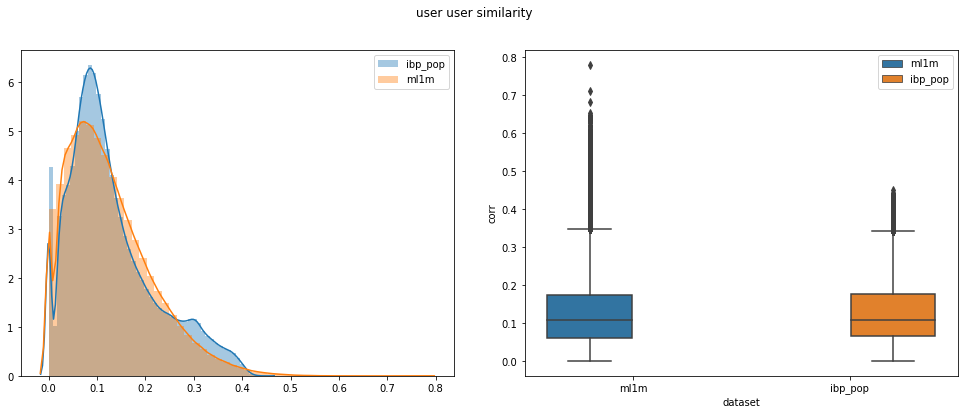

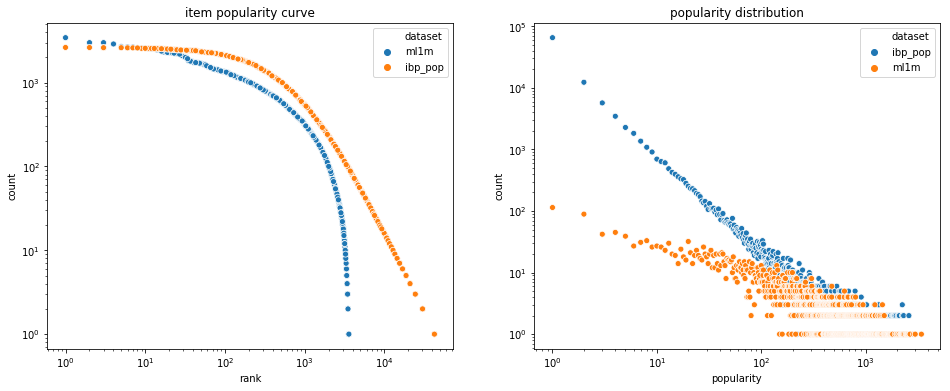

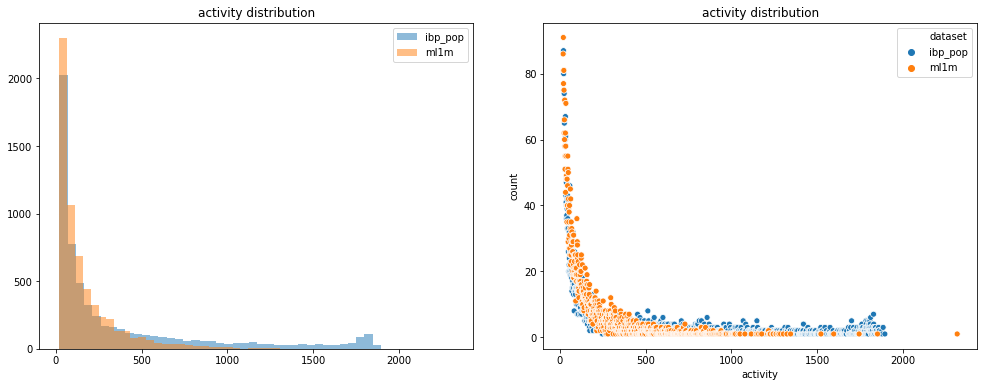

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040  107891  2248581  0.003451
item popularity stats
              ml1m        ibp_pop
count  3706.000000  107891.000000
mean    269.889099      20.841229
std     384.047838     132.167885
min       1.000000       1.000000
25%      33.000000       1.000000
50%     123.500000       1.000000
75%     350.000000       3.000000
max    3428.000000    2621.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517   372.281623
std     192.747029   486.485862
min      20.000000    22.000000
25%      44.000000    50.000000
50%      96.000000   137.000000
75%     208.000000   493.000000
max    2314.000000  1893.000000


In [38]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-ucorr-1-2019-04-05-18-31-40.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_ml1m_ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop_ml1m_ucorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', simulated_data))

### ibp pop on item pop

[20.000000000000004, 4.342722945458372, 0.0, 22.0, 0.1, 2545.4] 0.19725351890396395
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


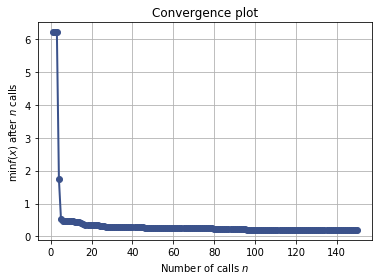

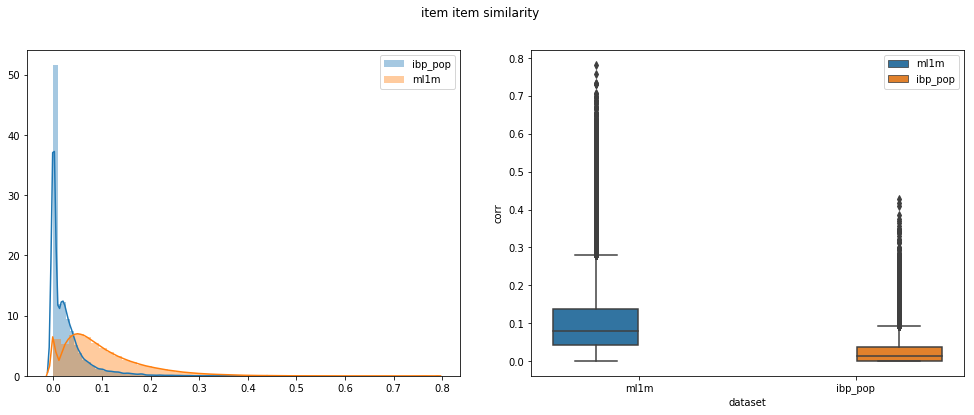

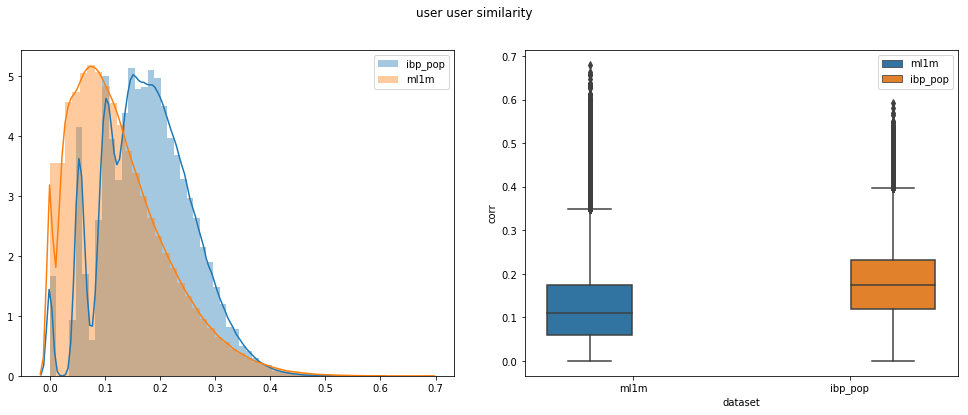

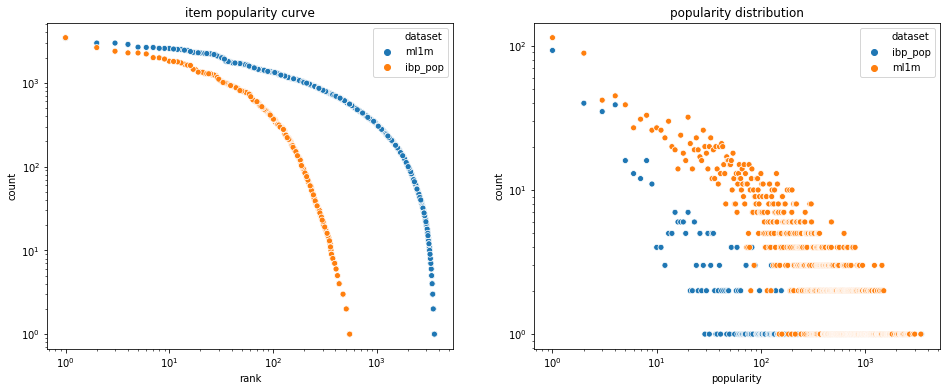

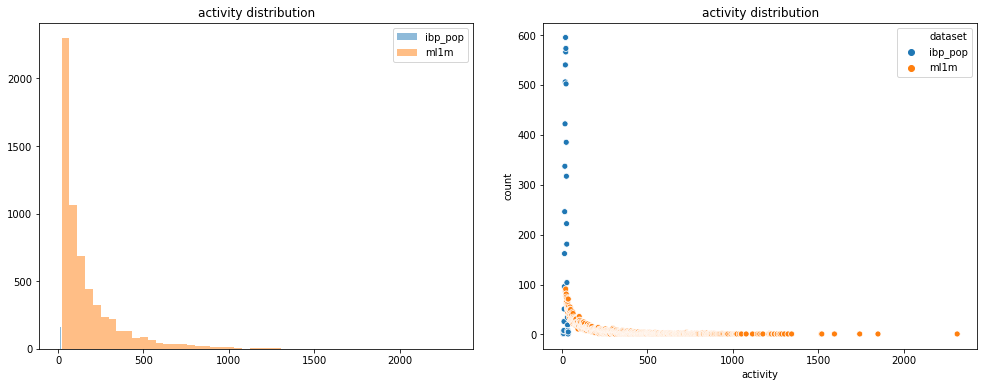

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040     640   124670  0.032251
item popularity stats
              ml1m      ibp_pop
count  3706.000000   640.000000
mean    269.889099   194.796875
std     384.047838   415.382249
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    18.000000
75%     350.000000   164.250000
max    3428.000000  3468.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517    20.640728
std     192.747029     4.066437
min      20.000000     6.000000
25%      44.000000    18.000000
50%      96.000000    21.000000
75%     208.000000    23.000000
max    2314.000000    36.000000


In [39]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-item-pop-1-2019-04-05-20-35-30.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_ml1m_ip.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop_ml1m_ip.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', simulated_data))

### ibp pop on user act

[4999.999999999999, 0.01, 0.0, 20.49174680904779, 0.3662436617256628, 2082.600000000001] 0.1222326454719343
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


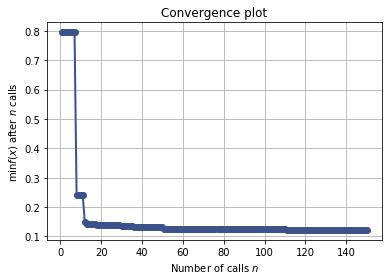

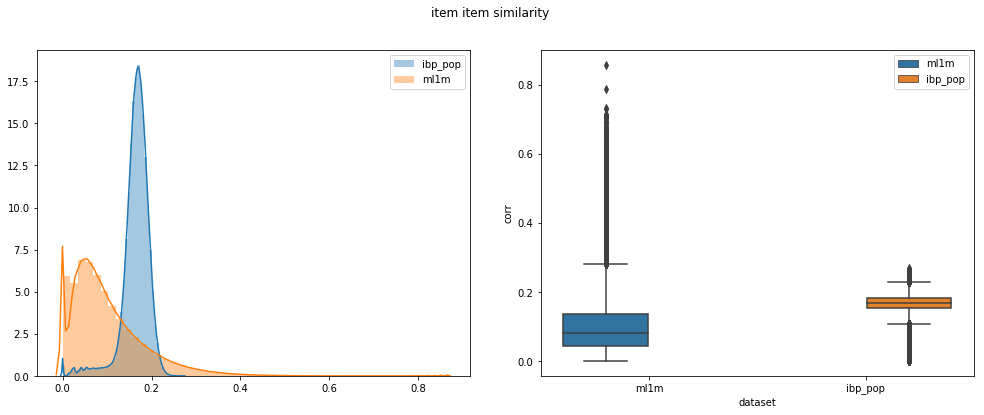

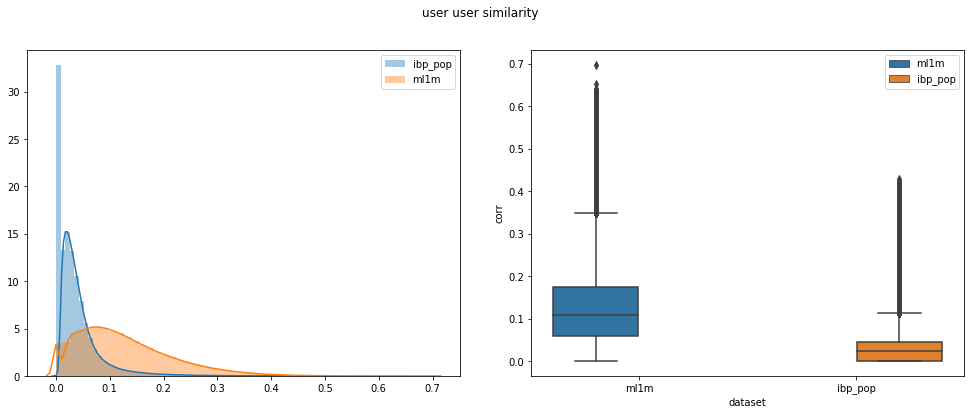

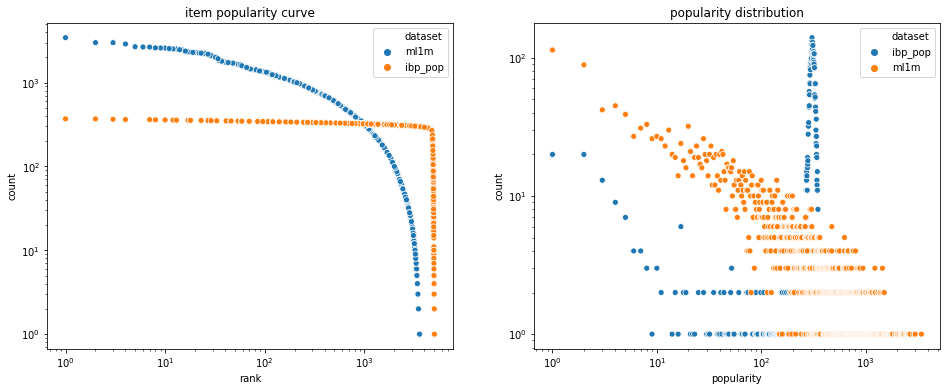

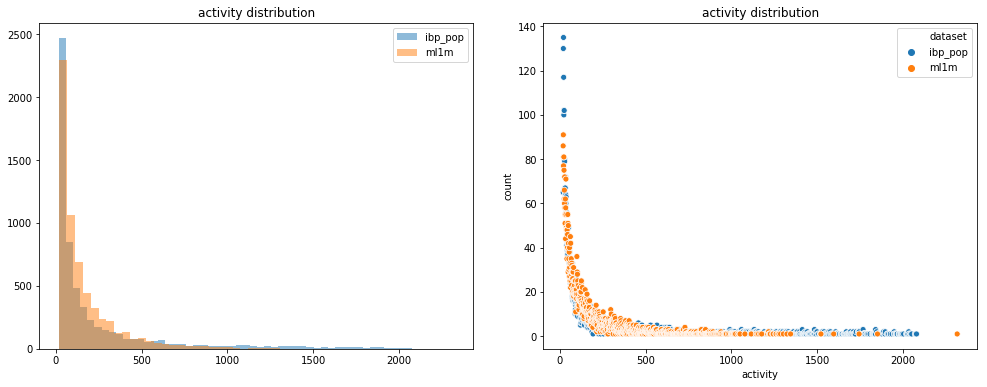

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040    5084  1513749  0.049296
item popularity stats
              ml1m      ibp_pop
count  3706.000000  5084.000000
mean    269.889099   297.747640
std     384.047838    55.147625
min       1.000000     1.000000
25%      33.000000   296.000000
50%     123.500000   308.000000
75%     350.000000   319.000000
max    3428.000000   369.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517   250.620695
std     192.747029   383.057084
min      20.000000    20.000000
25%      44.000000    37.750000
50%      96.000000    85.000000
75%     208.000000   267.250000
max    2314.000000  2077.000000


In [40]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-user-act-1-2019-04-05-18-33-18.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_ml1m_ua.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop_ml1m_ua.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', simulated_data))

### ibp pop on all

[389.32275354686044, 1.0466487147265098, 0.0, 22.0, 0.6304834173274515, 2082.600000000001] 1.827147156895655
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


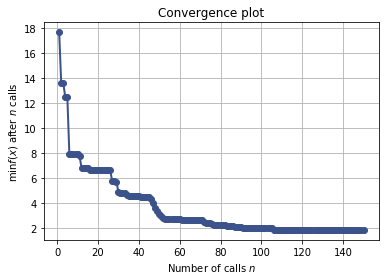

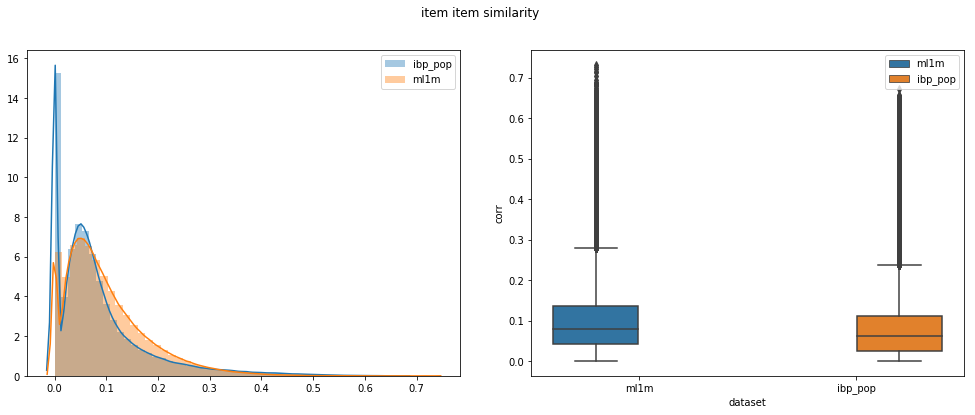

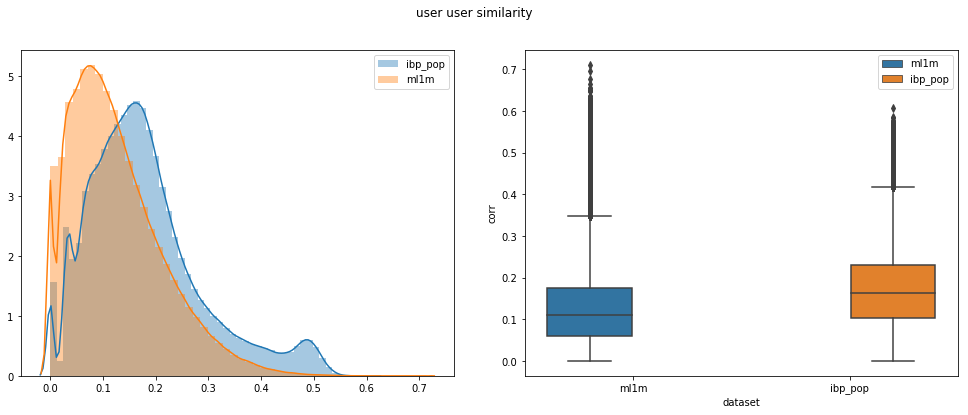

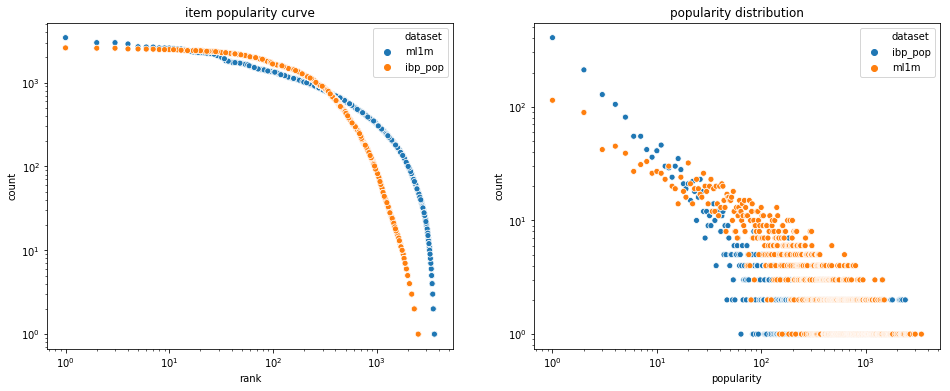

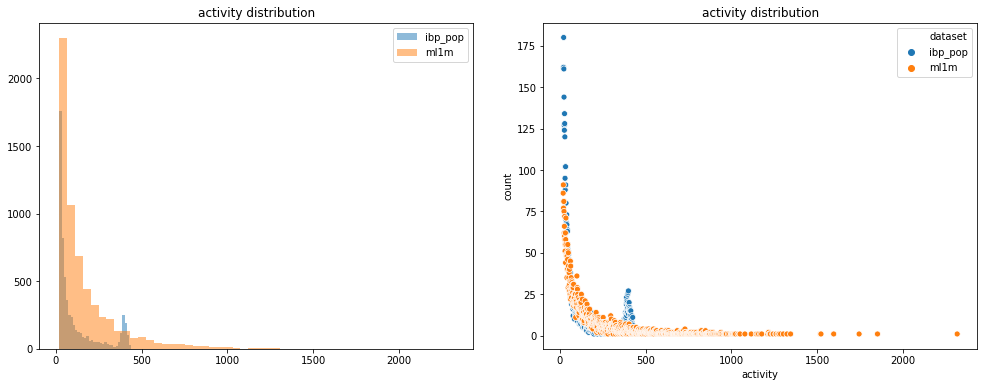

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040    2914   725493  0.041220
item popularity stats
              ml1m      ibp_pop
count  3706.000000  2914.000000
mean    269.889099   248.968085
std     384.047838   494.342105
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    21.500000
75%     350.000000   203.750000
max    3428.000000  2589.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517   120.114735
std     192.747029   124.767014
min      20.000000    22.000000
25%      44.000000    33.000000
50%      96.000000    59.000000
75%     208.000000   155.000000
max    2314.000000   440.000000


In [41]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-all-1-2019-04-05-22-27-46.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_ml1m_all.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop_ml1m_all.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', simulated_data))

### ibp pop on relative loss

[92.52828925488583, 0.7228574867783069, 0.08363757235606883, 19.98847887732374, 3.4347491831956405, 1530.591791863939] 214.73080435733914
simulated data is used


/home/mtian/IdeaProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:77: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040     420   168145  0.066282
item popularity stats
              ml1m      ibp_pop
count  3706.000000   420.000000
mean    269.889099   400.345238
std     384.047838   702.796027
min       1.000000     1.000000
25%      33.000000     5.000000
50%     123.500000    36.500000
75%     350.000000   457.250000
max    3428.000000  3060.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517    27.838576
std     192.747029    10.772617
min      20.000000    19.000000
25%      44.000000    21.000000
50%      96.000000    24.000000
75%     208.000000    30.000000
max    2314.000000    98.000000


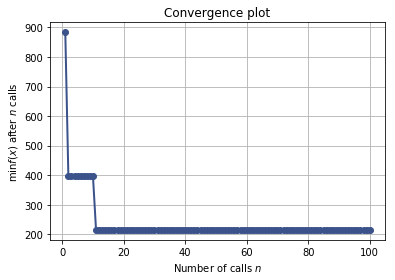

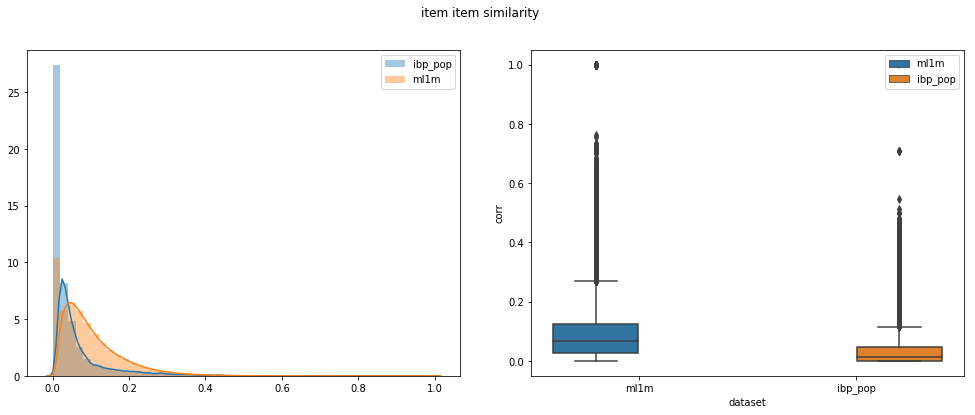

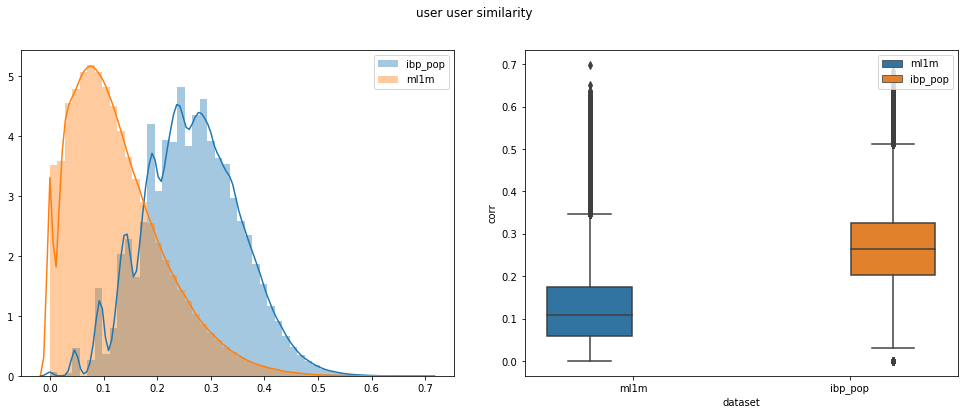

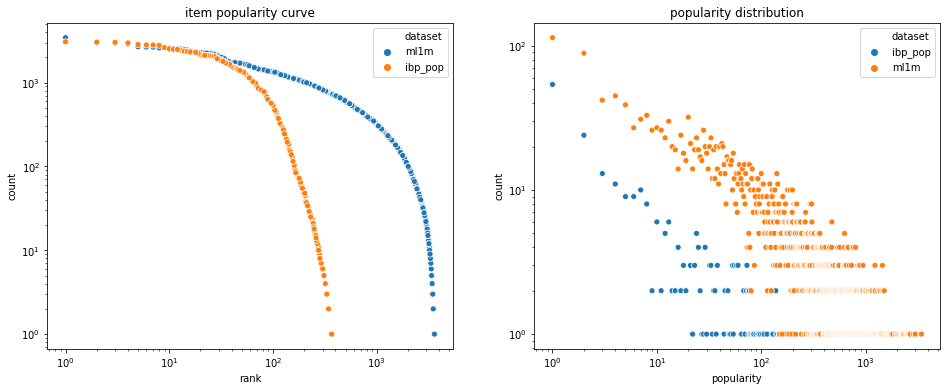

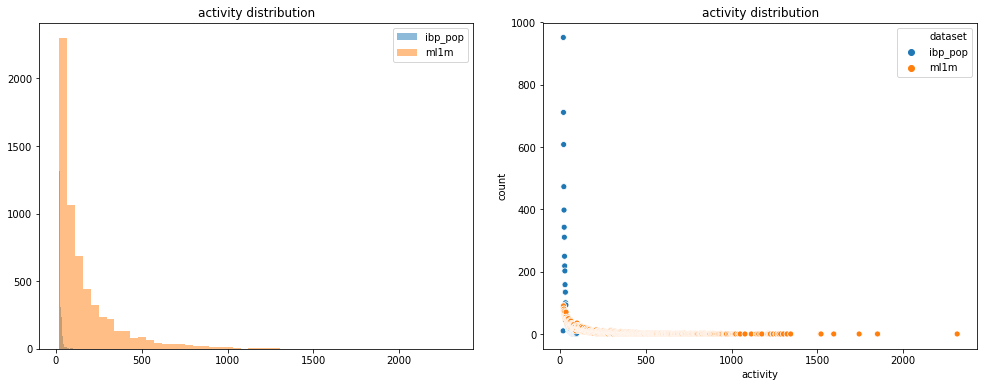

In [15]:
res_gp = skopt.load('build/skopt_ibp_pop-ml_1m.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop-ml_1m.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', ibp_pop_pareto), args=[6040, *res_gp.x, 'ibp_pop-ml_1m.pkl'])
else:
    print('simulated data is used')
    plot_stats(('ml1m', ml_1m), ('ibp_pop', simulated_data))